In [1]:
from helper_funcs_kdd import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import io
from tqdm import tqdm
import time
dpi = 200


9.423999999999978 8.90850590736188
20.355094660139457 22.26044497636162
-3.378986128191741 7.961313871418157
-5.045880345794529 10.136525021774162


In [2]:
# daily highway incidents in california highway from start of 2017 to end of 2020
cal_data = pd.read_excel('../data/CalTransit_Dataset/pems_output.xlsx')
print(cal_data.head(10))
cal_data.rename({"Time": "x", "# Incidents": "y"}, axis=1, inplace=True)
print(len(cal_data))

        Time  # Incidents
0 2017-01-01          862
1 2017-01-02          887
2 2017-01-03         1483
3 2017-01-04         1570
4 2017-01-05         1532
5 2017-01-06         1535
6 2017-01-07         1311
7 2017-01-08         1296
8 2017-01-09         1495
9 2017-01-10         1676
1461


<Figure size 1000x600 with 0 Axes>

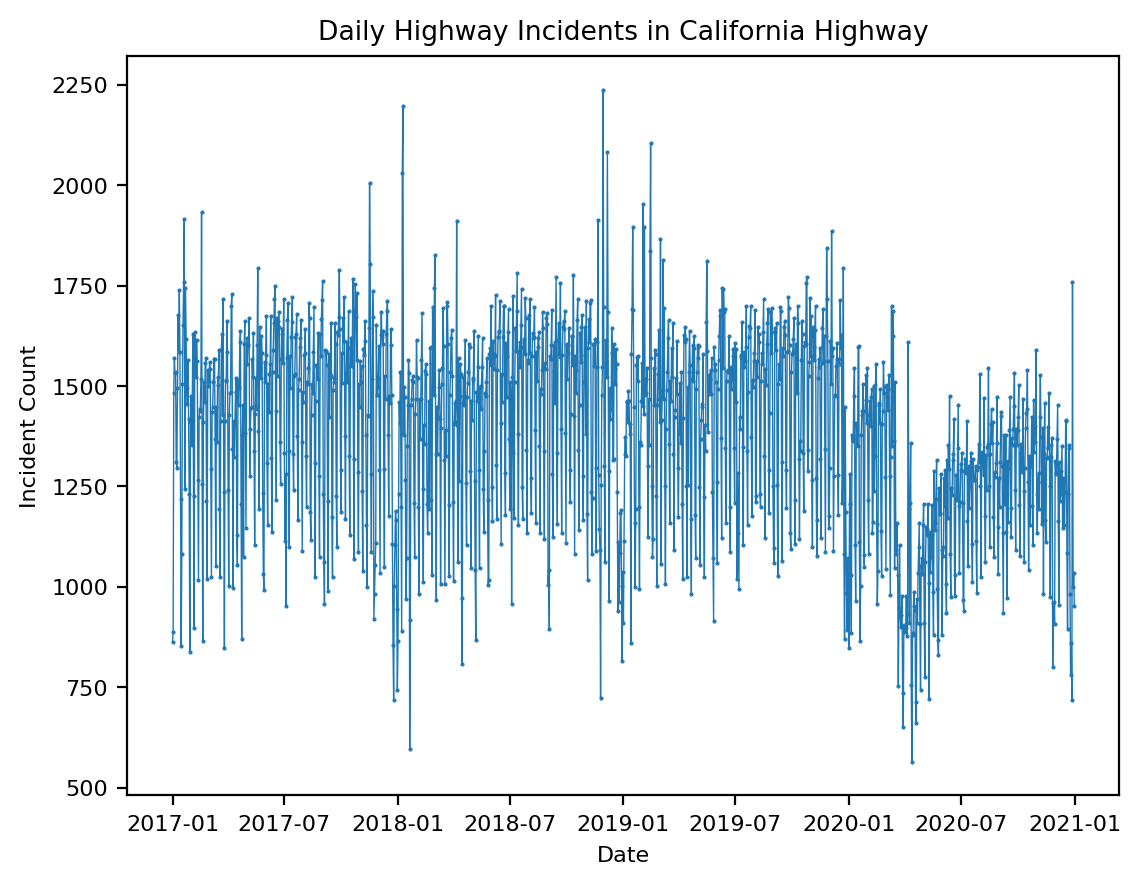

In [31]:
# plot the time series
# use thinner lines
plt.figure(figsize=(10, 6))
plt.figure(dpi=dpi)
plt.rcParams.update({'font.size': 8})
plt.plot(cal_data['x'], cal_data['y'], linewidth=0.5,marker='o',markersize=0.5)
plt.title('Daily Highway Incidents in California Highway')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.show()


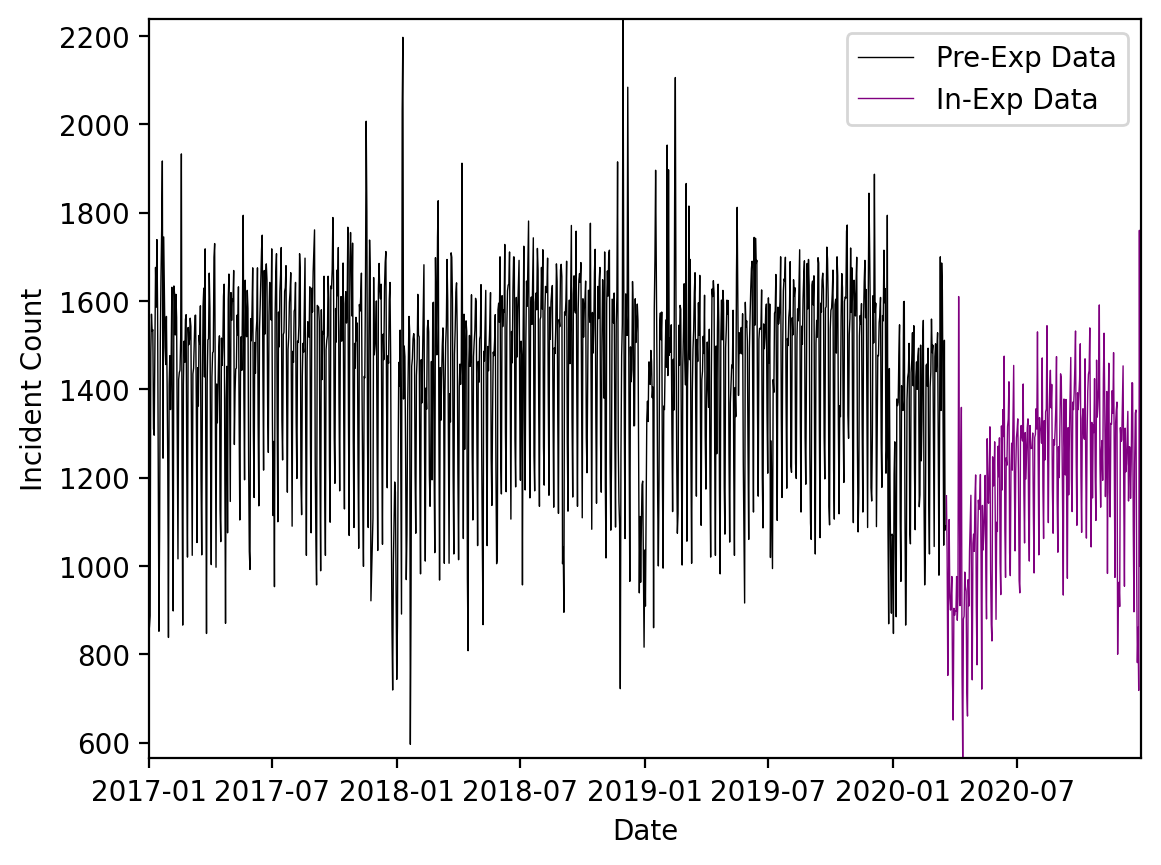

In [3]:
plt.figure(dpi=dpi)

# Separate train, validation, test data
n = cal_data.shape[0]
# pandemic lockdown started march 19 in california
train_df = cal_data[cal_data['x'] < '2020-03-19'].reset_index(drop=True)
test_df = cal_data[cal_data['x']>='2020-03-19'].reset_index(drop=True)
# convert date in test data to integer, with minimum date being 0 - this is for regression and secondary adjustment later
test_df['x1'] = (test_df['x'] - min(test_df['x'])).dt.days
# plot
x_range = [min(cal_data['x']), max(cal_data['x'])]
y_range = [min(cal_data['y']), max(cal_data['y'])]
plt.plot(train_df['x'], train_df['y'], color='black',linewidth=0.5,label='Pre-Exp Data')
plt.plot(test_df['x'], test_df['y'], color='purple',linewidth=0.5,label='In-Exp Data')
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("Date")
ax.set_ylabel("Incident Count")
ax.legend()
plt.show()

<Figure size 1280x960 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

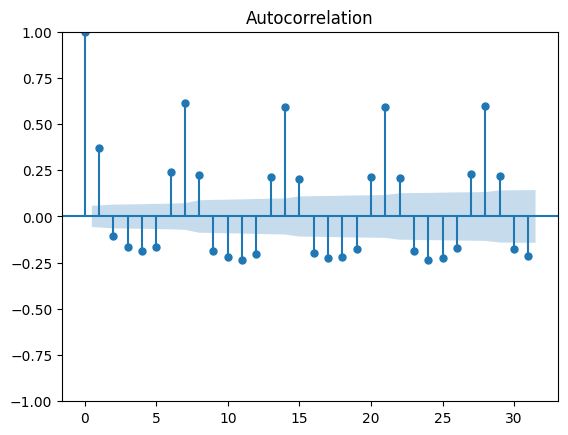

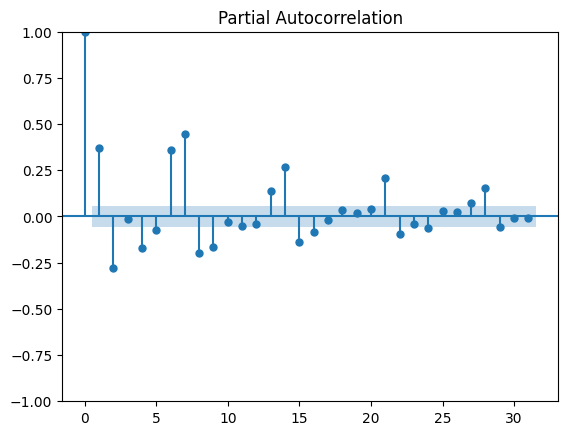

In [7]:
# plot autocorrelation and partial autocorrelation side by side
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(train_df['y'])
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(train_df['y'])
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1280x960 with 0 Axes>

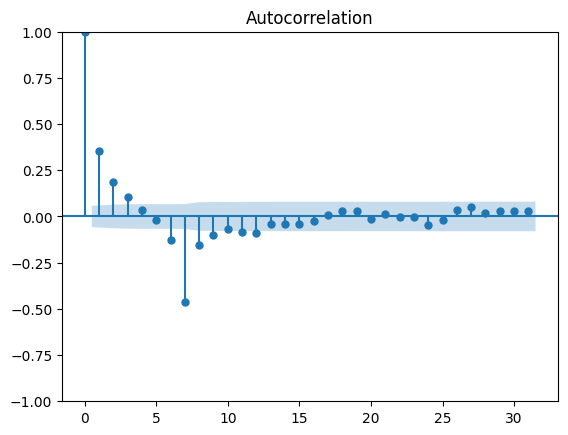

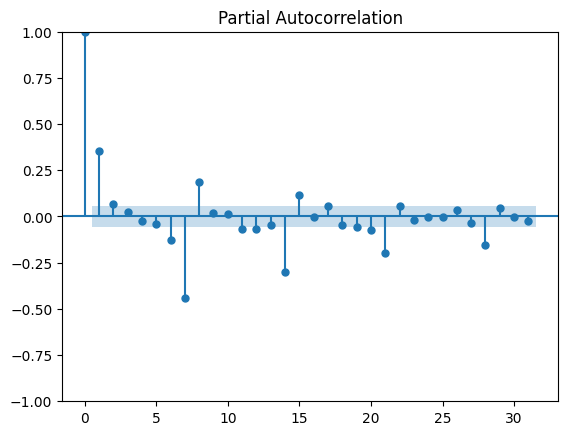

In [8]:
# seasonally differenced data, plot acf and pacf again
diff_y  = train_df['y'].diff(7).dropna()
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_acf(diff_y)
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(diff_y)
plt.title('Partial Autocorrelation')
plt.show()

In [ ]:
# Choose parameters to try fitting the model with
p = [0,1]
q = [0,1]
d = [0,1]
P = [0,1]
Q = [0,1]
D = [0,1] # dont need to test 0,1, just remove 1 if testing as run takes too long
S = [7]
#D = [0]
param1 = list(itertools.product(p,d,q))
param2 = list(itertools.product(P,D,Q,S))
best_param1 = param1[0]
best_param2 = param2[0]
for i in range(len(param1)):
    for j in range(len(param2)):
        #print(i,j)
        model = sm.tsa.statespace.SARIMAX(train_df['y'], order = param1[i], seasonal_order = param2[j])
        result = model.fit(disp=False)
        tb = result.summary().tables[0].as_html()
        readable_tb = pd.read_html(io.StringIO(tb),header=None,index_col=None)[0] 
        cur_aic = readable_tb[3][2]
        if i == 0 and j == 0:
            best_aic = cur_aic
        elif cur_aic < best_aic:
            best_aic = cur_aic
            best_param1 = param1[i]
            best_param2 = param2[j]
best_aic, best_param1, best_param2
opt_model = sm.tsa.statespace.SARIMAX(train_df['y'], order = best_param1, seasonal_order = best_param2)


/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/Mast

(np.float64(14811.958), (1, 0, 1), (0, 1, 1, 7))

<Figure size 2000x1200 with 0 Axes>

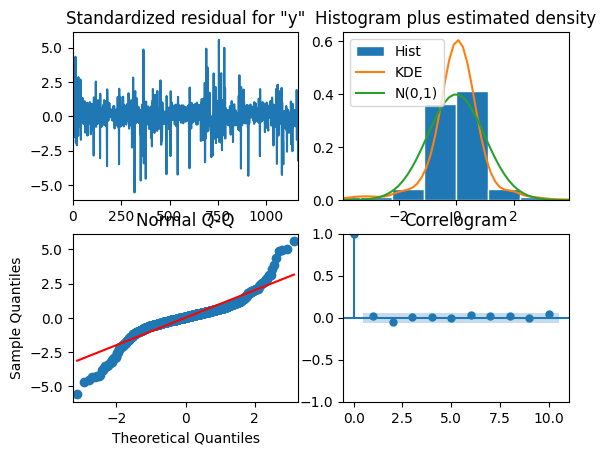

In [ ]:
# fit the best model and check residuals
plt.figure(figsize=(10, 6),dpi=dpi)
opt_res = opt_model.fit(disp=False)
opt_res.plot_diagnostics()
plt.show()

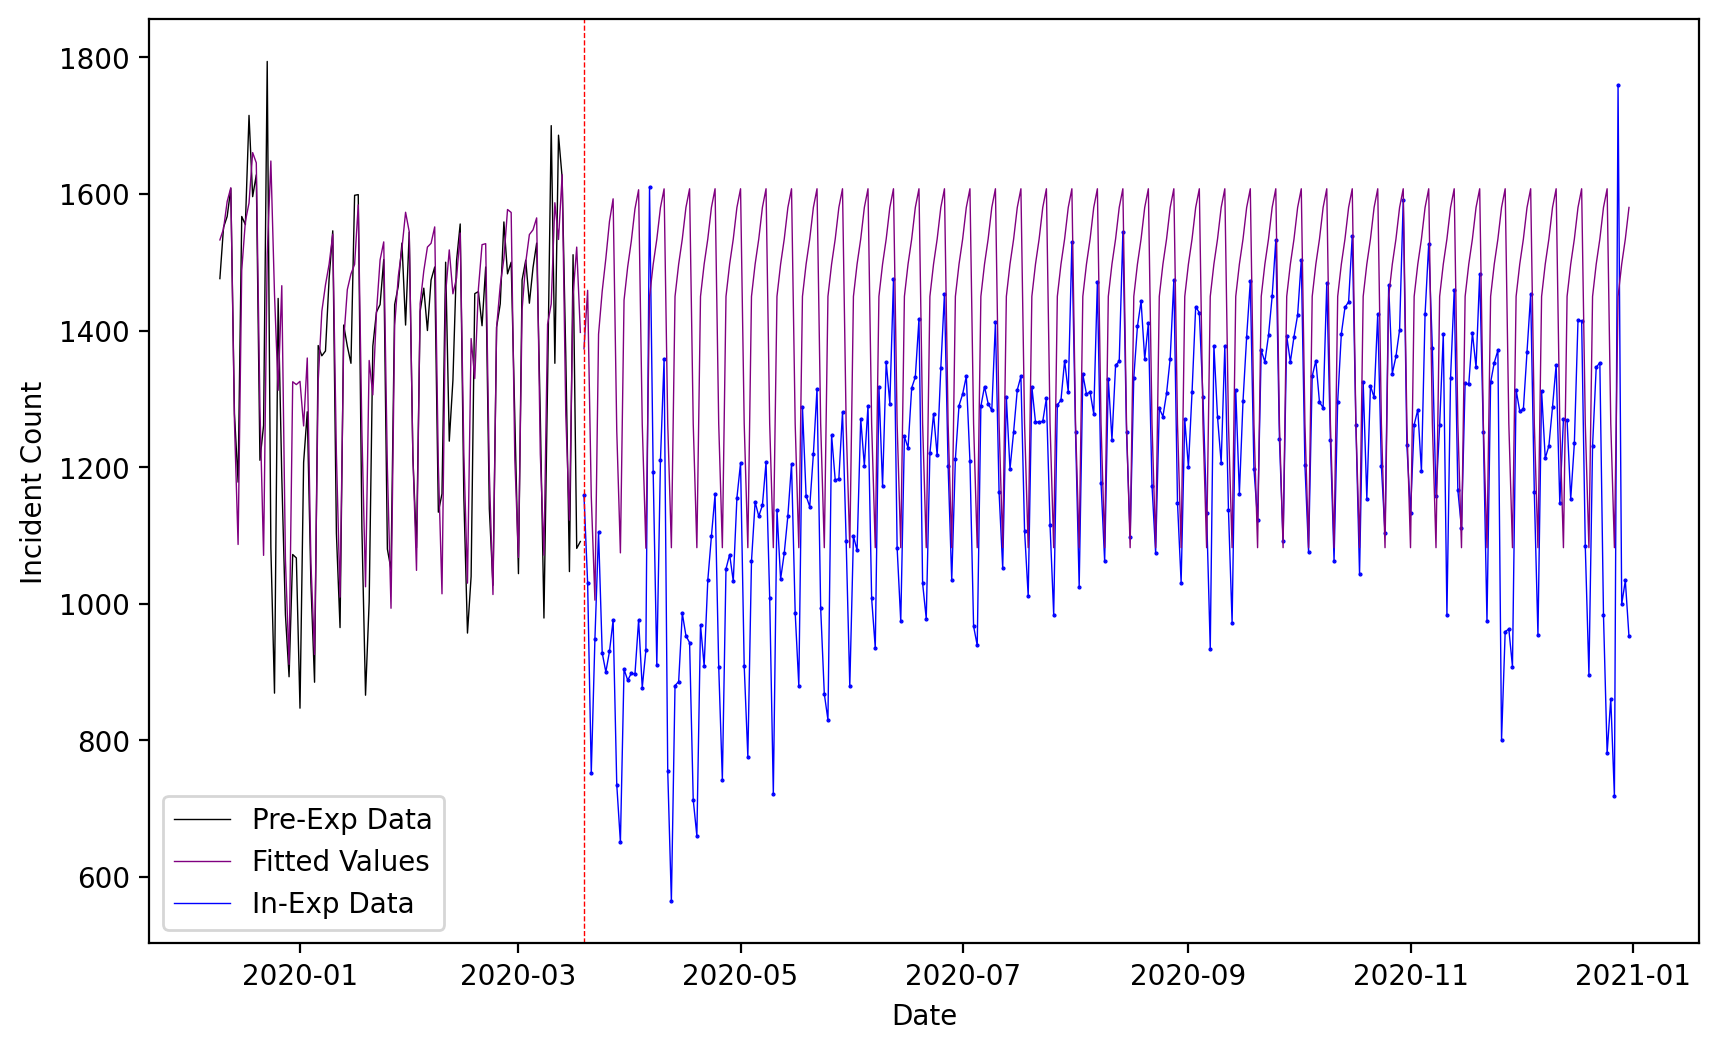

In [8]:
# predict values for test data and plot against actual test data
plt.figure(figsize=(10,6), dpi = dpi)
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)) # watch index here as it is reset when train test split
pred_mean = pred.predicted_mean
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'], test_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(test_df['x'], test_df['y'], color='blue', linewidth = 0.5, label='In-Exp Data')
plt.plot(test_df['x'], pred_mean, color='purple', ls = '-', linewidth=0.5)
# plot a vertical line to show the start of the test data
plt.axvline(x=test_df['x'].iloc[0], color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend()
plt.show()



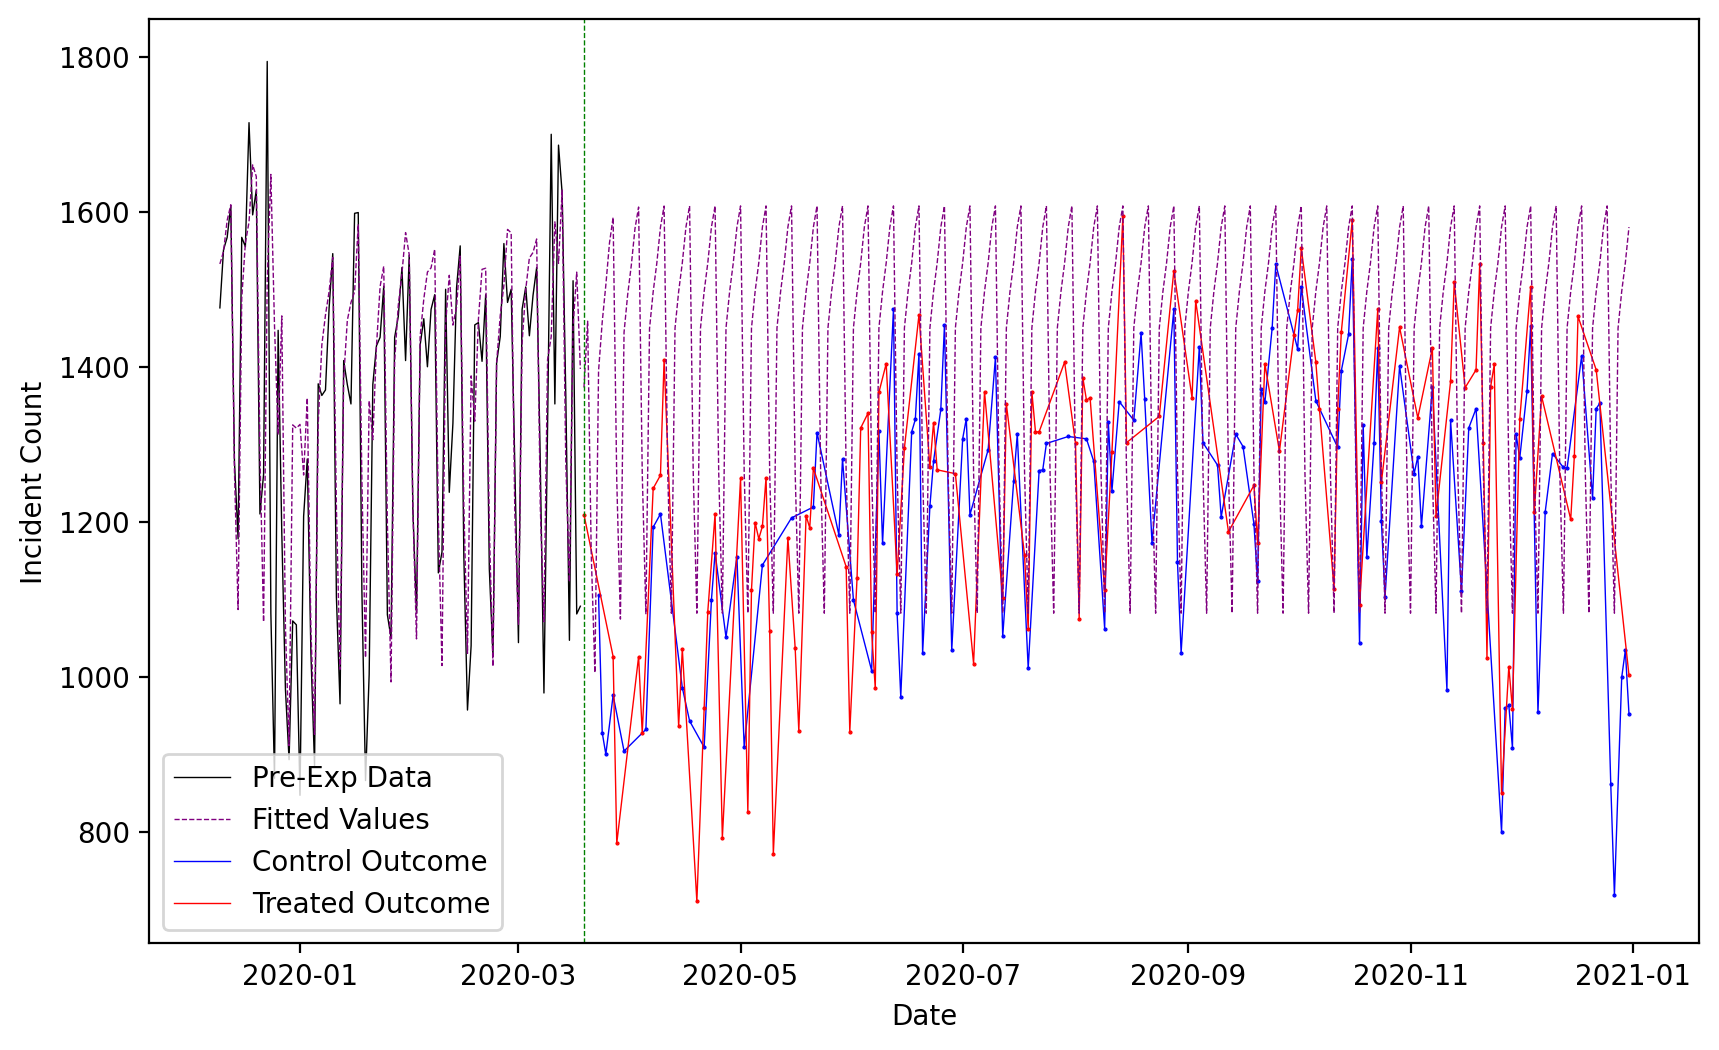

In [64]:
# simulate experiment by randomly assigning treatment to some data points
np.random.seed(2)
# treatment effect - say increase of 50 incidents
test_len = len(test_df)
n = test_len//2
te = 50
# randomly assign treatment
control_df = test_df[test_df['treatment'] == 0].reset_index(drop=True)
treatment_df = test_df[test_df['treatment'] == 1].reset_index(drop=True)
treatment_idx = np.random.choice(range(test_len), n, replace=True)
control_idx = np.random.choice(range(test_len), n, replace=True)
treatment_df = test_df[test_df.index.isin(treatment_idx)].reset_index(drop=True)
control_df = test_df[test_df.index.isin(control_idx)].reset_index(drop=True)
treatment_df['y'] = treatment_df['y'] + te
# plot the above plot but with treated
plt.figure(figsize=(10,6), dpi = dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', ls = '--', linewidth=0.5, label='Fitted Values')
plt.plot(control_df['x'], control_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(control_df['x'], control_df['y'], color='blue', linewidth = 0.5, label='Control Outcome')
plt.plot(treatment_df['x'], treatment_df['y'], 'o', color='red', markersize = 0.5)
plt.plot(treatment_df['x'], treatment_df['y'], color='red', linewidth = 0.5, label='Treated Outcome')
plt.plot(test_df['x'], pred_mean, color='purple', ls = '--', linewidth=0.5)
plt.axvline(x=test_df['x'].iloc[0], color='green', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend(loc='lower left')
plt.show()

In [6]:
# run simulation

# set seed for reproducibility
np.random.seed(1)

# simulation parameters
te_lst = [0, 20, 50, 100, 200]
n_lst = [100, 200, 500, 1000]
r = 10000
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)).predicted_mean.reset_index(drop=True)
test_df_clean = traffic_preprocess(test_df.copy()) # get rid of the date, convert to integer

# save results here
# pre-determine size for efficiency
total = len(te_lst)*len(n_lst)*r
rows = np.zeros((total, 8))

# set up tqdm in the outer loop 
with tqdm(total=total, desc="Overall Progress") as pbar:
    idx = 0
    for te in te_lst: 
        for n in n_lst:
            for i in range(r):
                # randomly generate an instance of experiment data
                control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(test_df_clean, te, n)

                # constant model
                ate, se = calculate_ate(control_df, treatment_df)
                row = [ate, se]

                # regression model
                ate, se = calculate_ate_reg(control_df, treatment_df)
                row.extend([ate, se])

                # prediction model
                #print(control_df, control_idx)
                ate, se = calculate_ate_pred(control_df, treatment_df, pred, control_idx, treatment_idx)
                row.extend([ate, se])

                # secondary adjustment model
                ate, se = calculate_ate_sec(control_df, treatment_df, pred, control_idx, treatment_idx)
                row.extend([ate, se])
                
                rows[idx, :] = row
                idx += 1
                pbar.update(1)

# convert to dataframe
colnames = ['Constant ATE', 'Constant SE', 'Regression ATE', 'Regression SE', 'Prediction ATE', 'Prediction SE', 'Secondary ATE', 'Secondary SE']
results = pd.DataFrame(rows, columns=colnames)

            


Overall Progress: 100%|██████████| 200000/200000 [03:48<00:00, 876.62it/s]


KeyError: 'n'

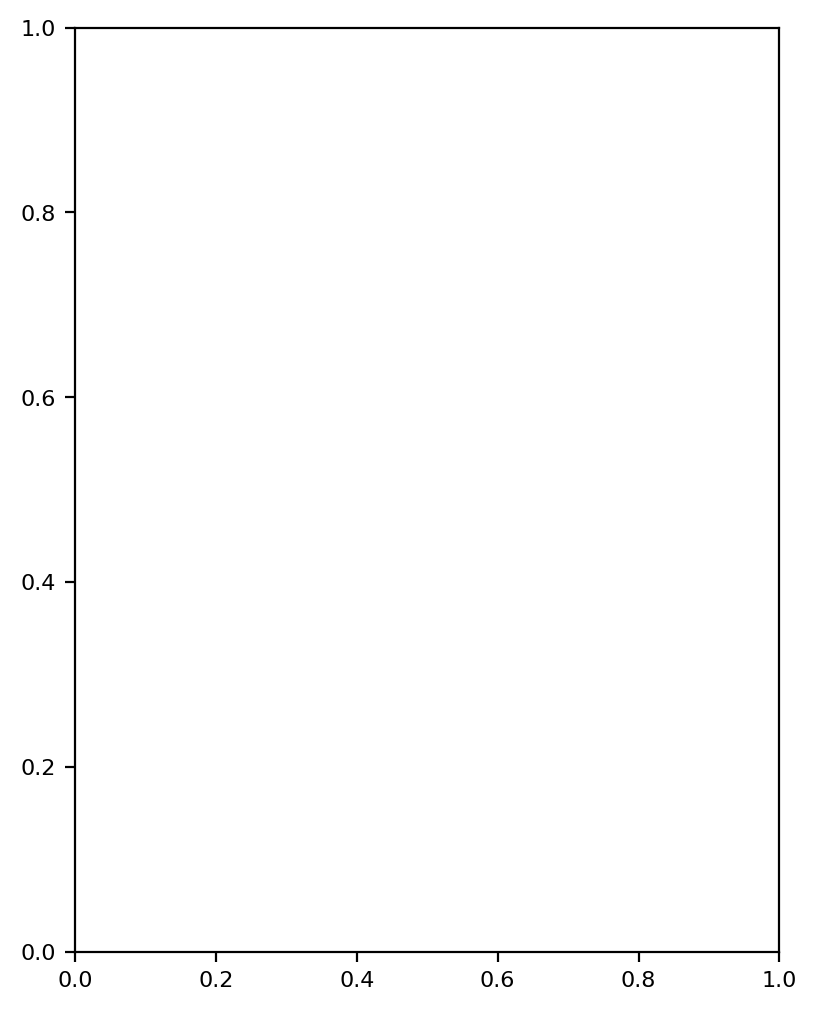

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


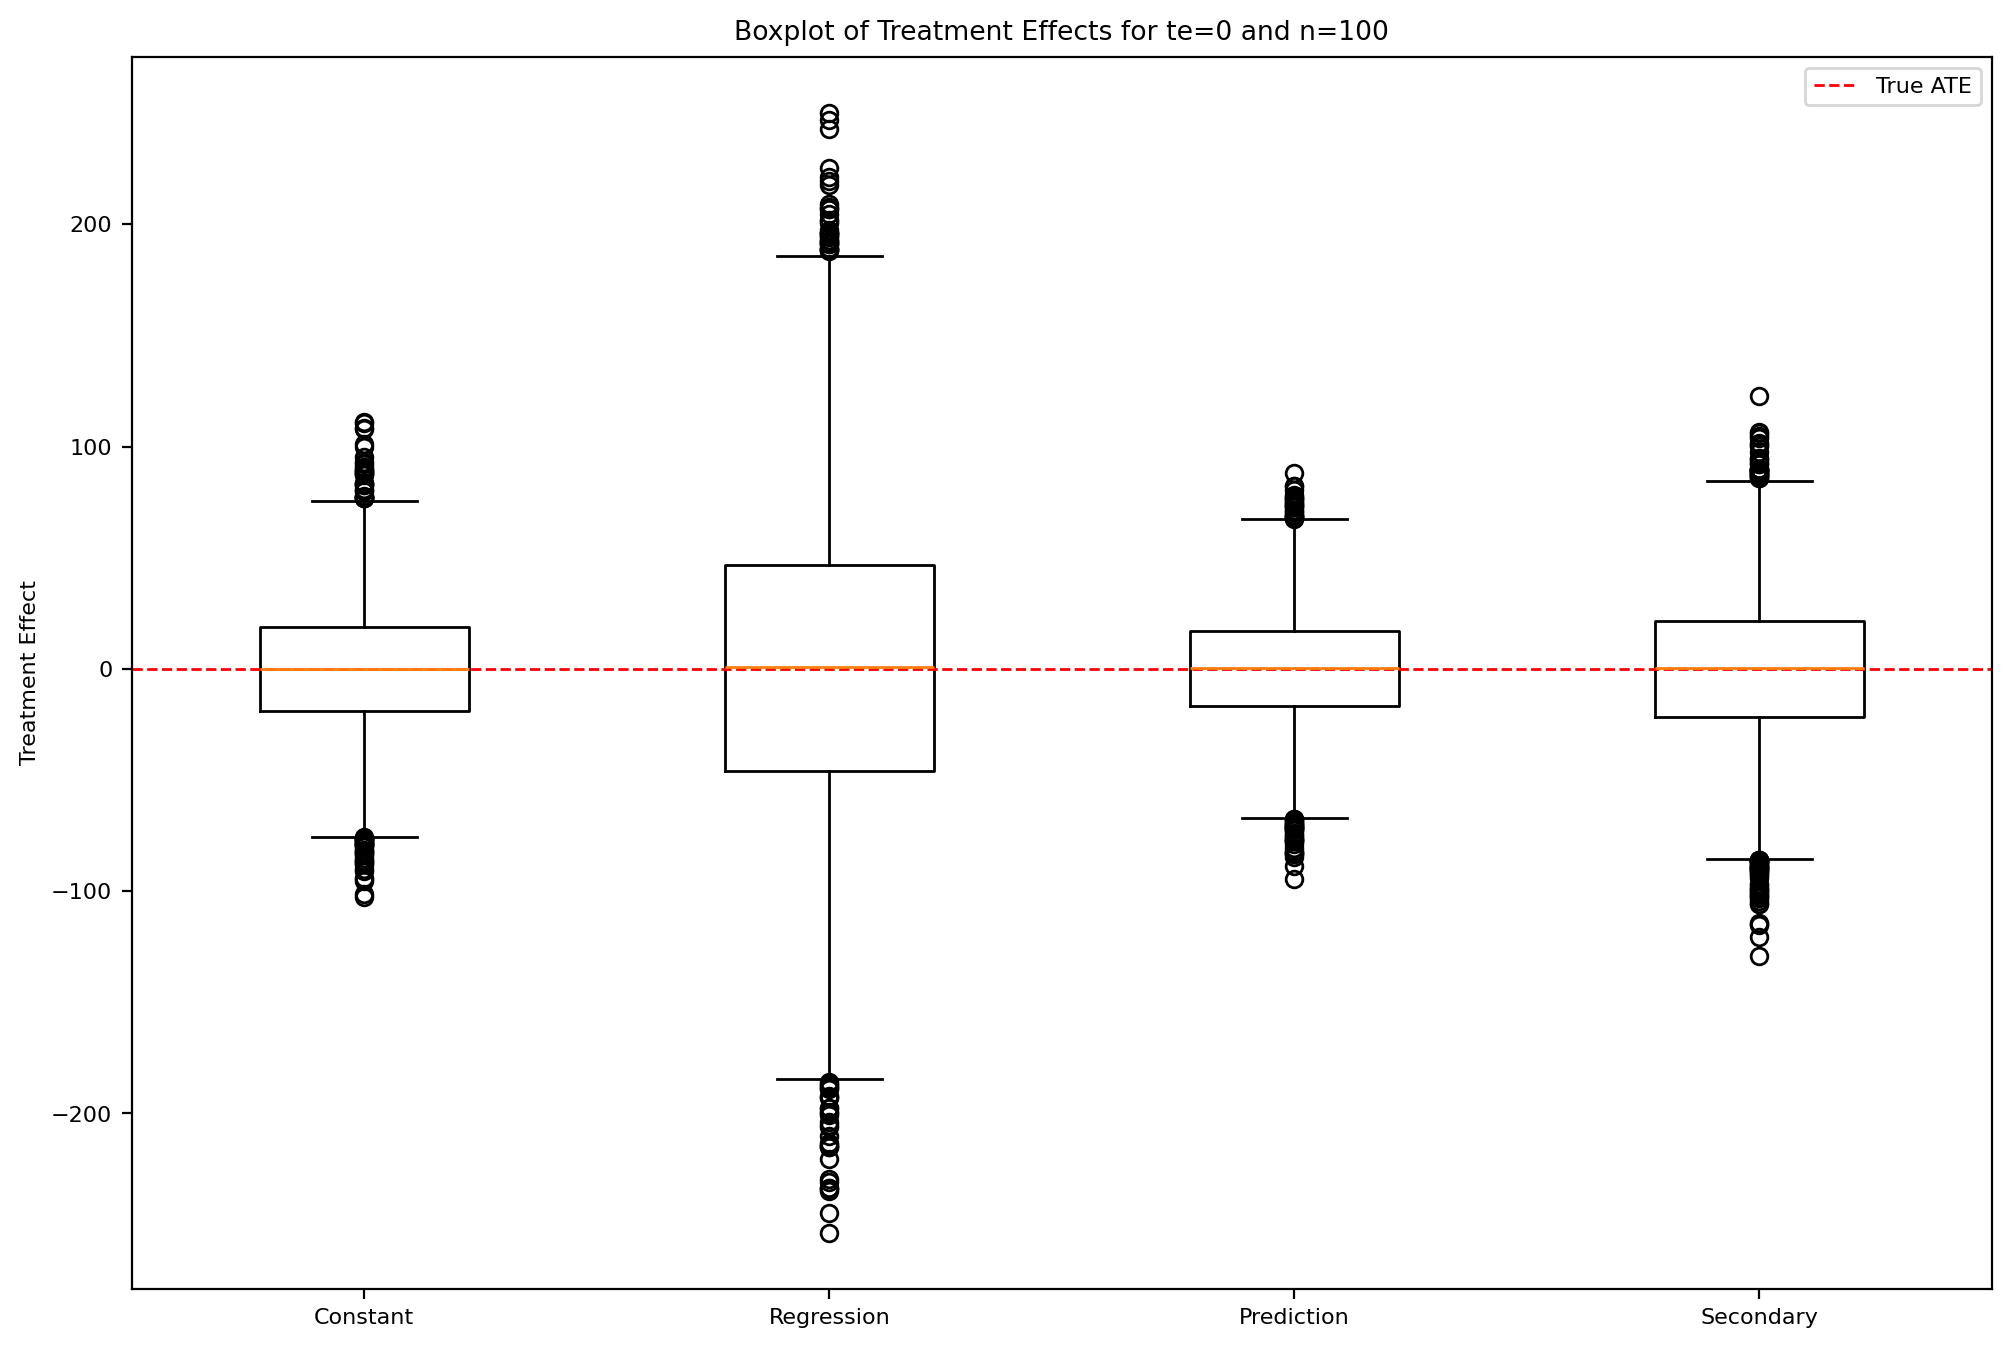

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


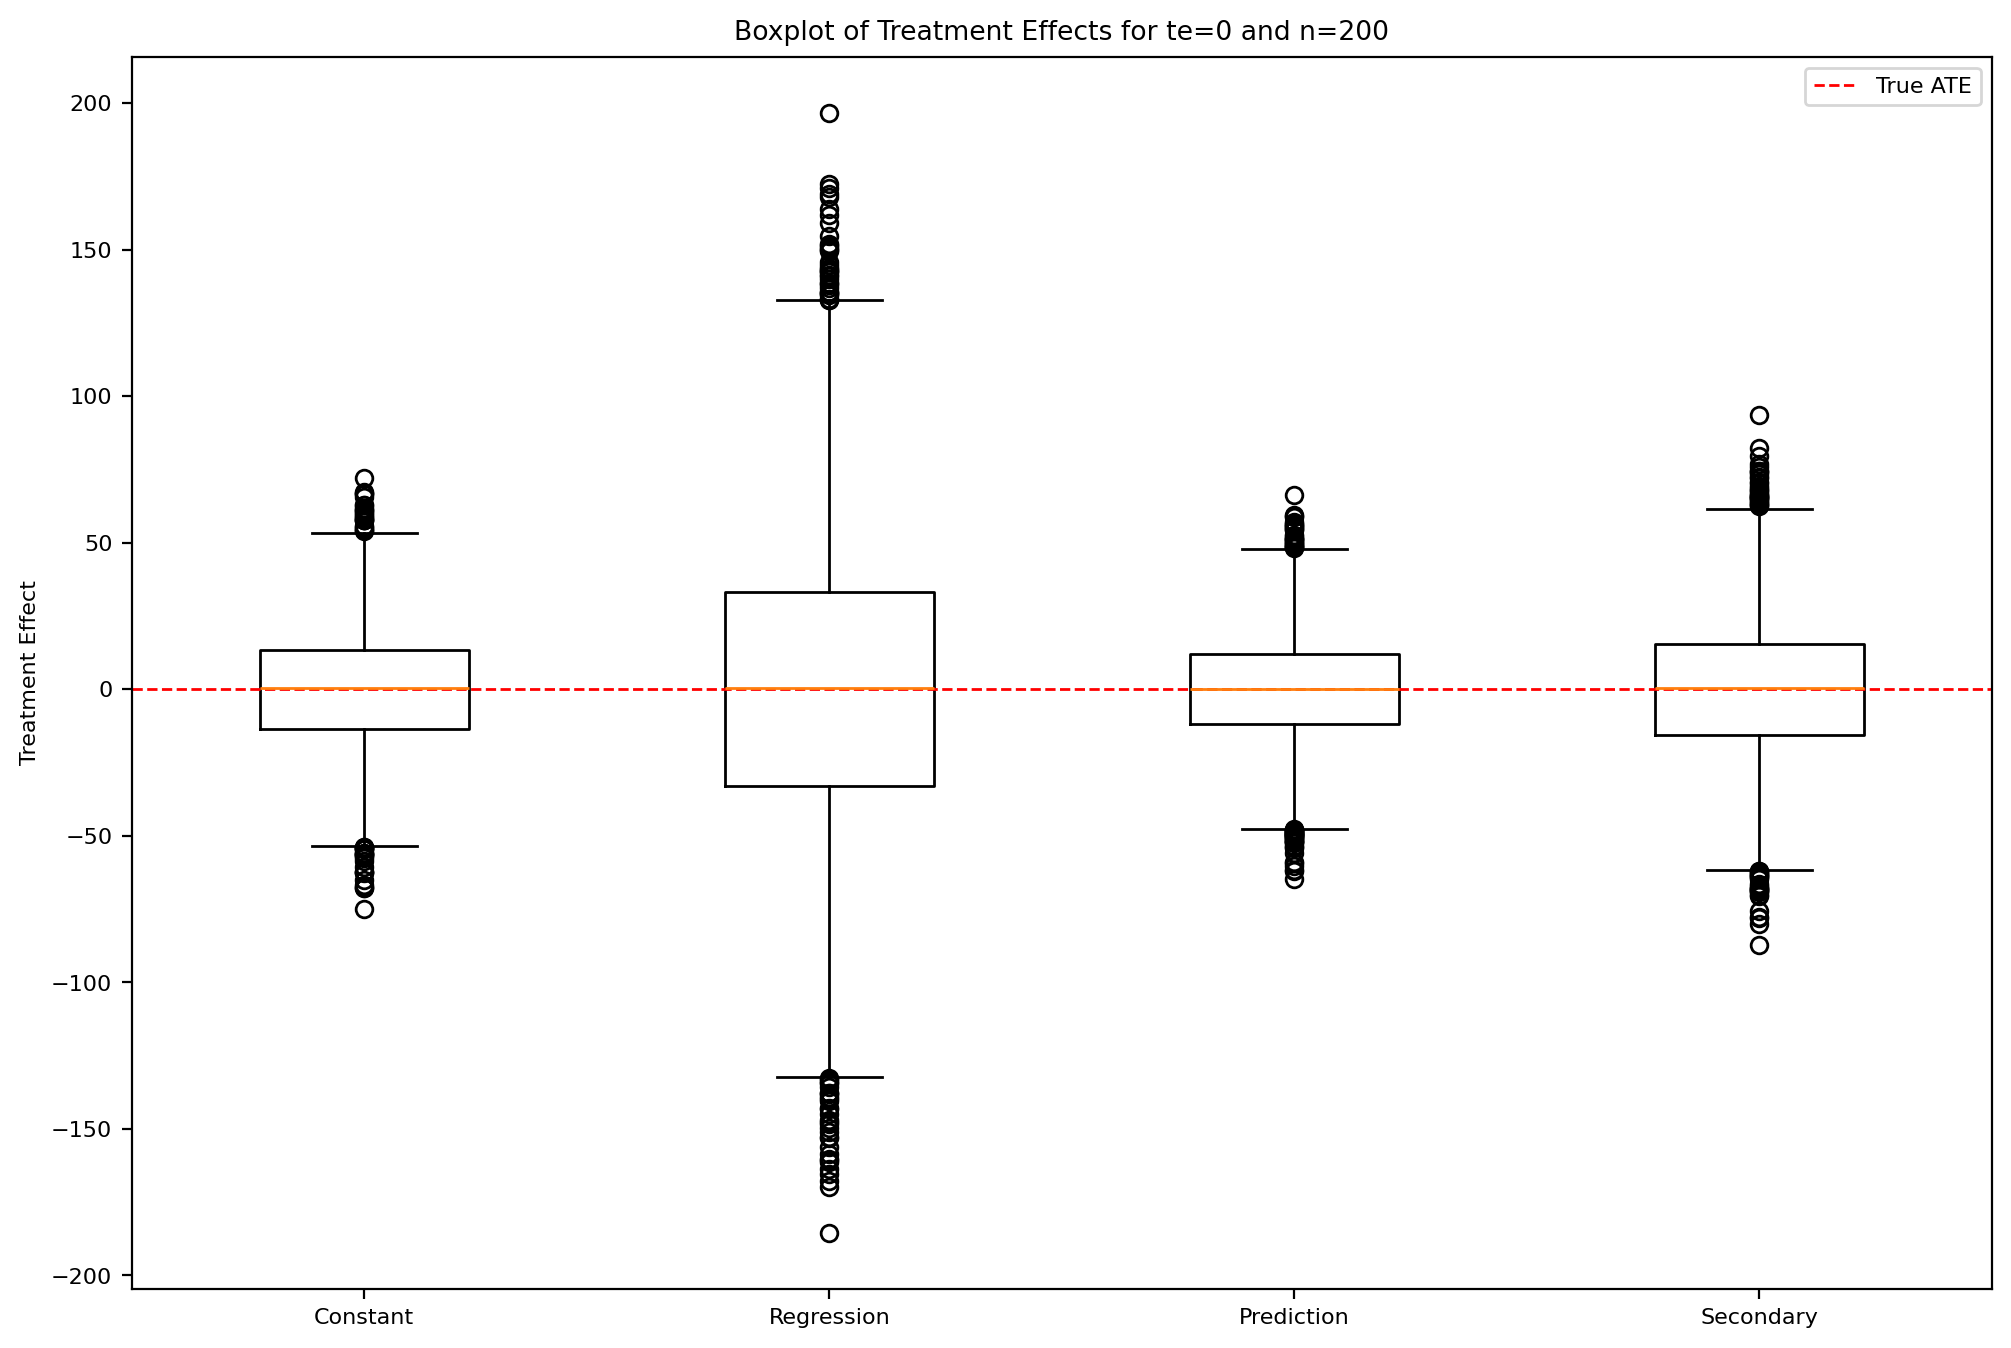

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


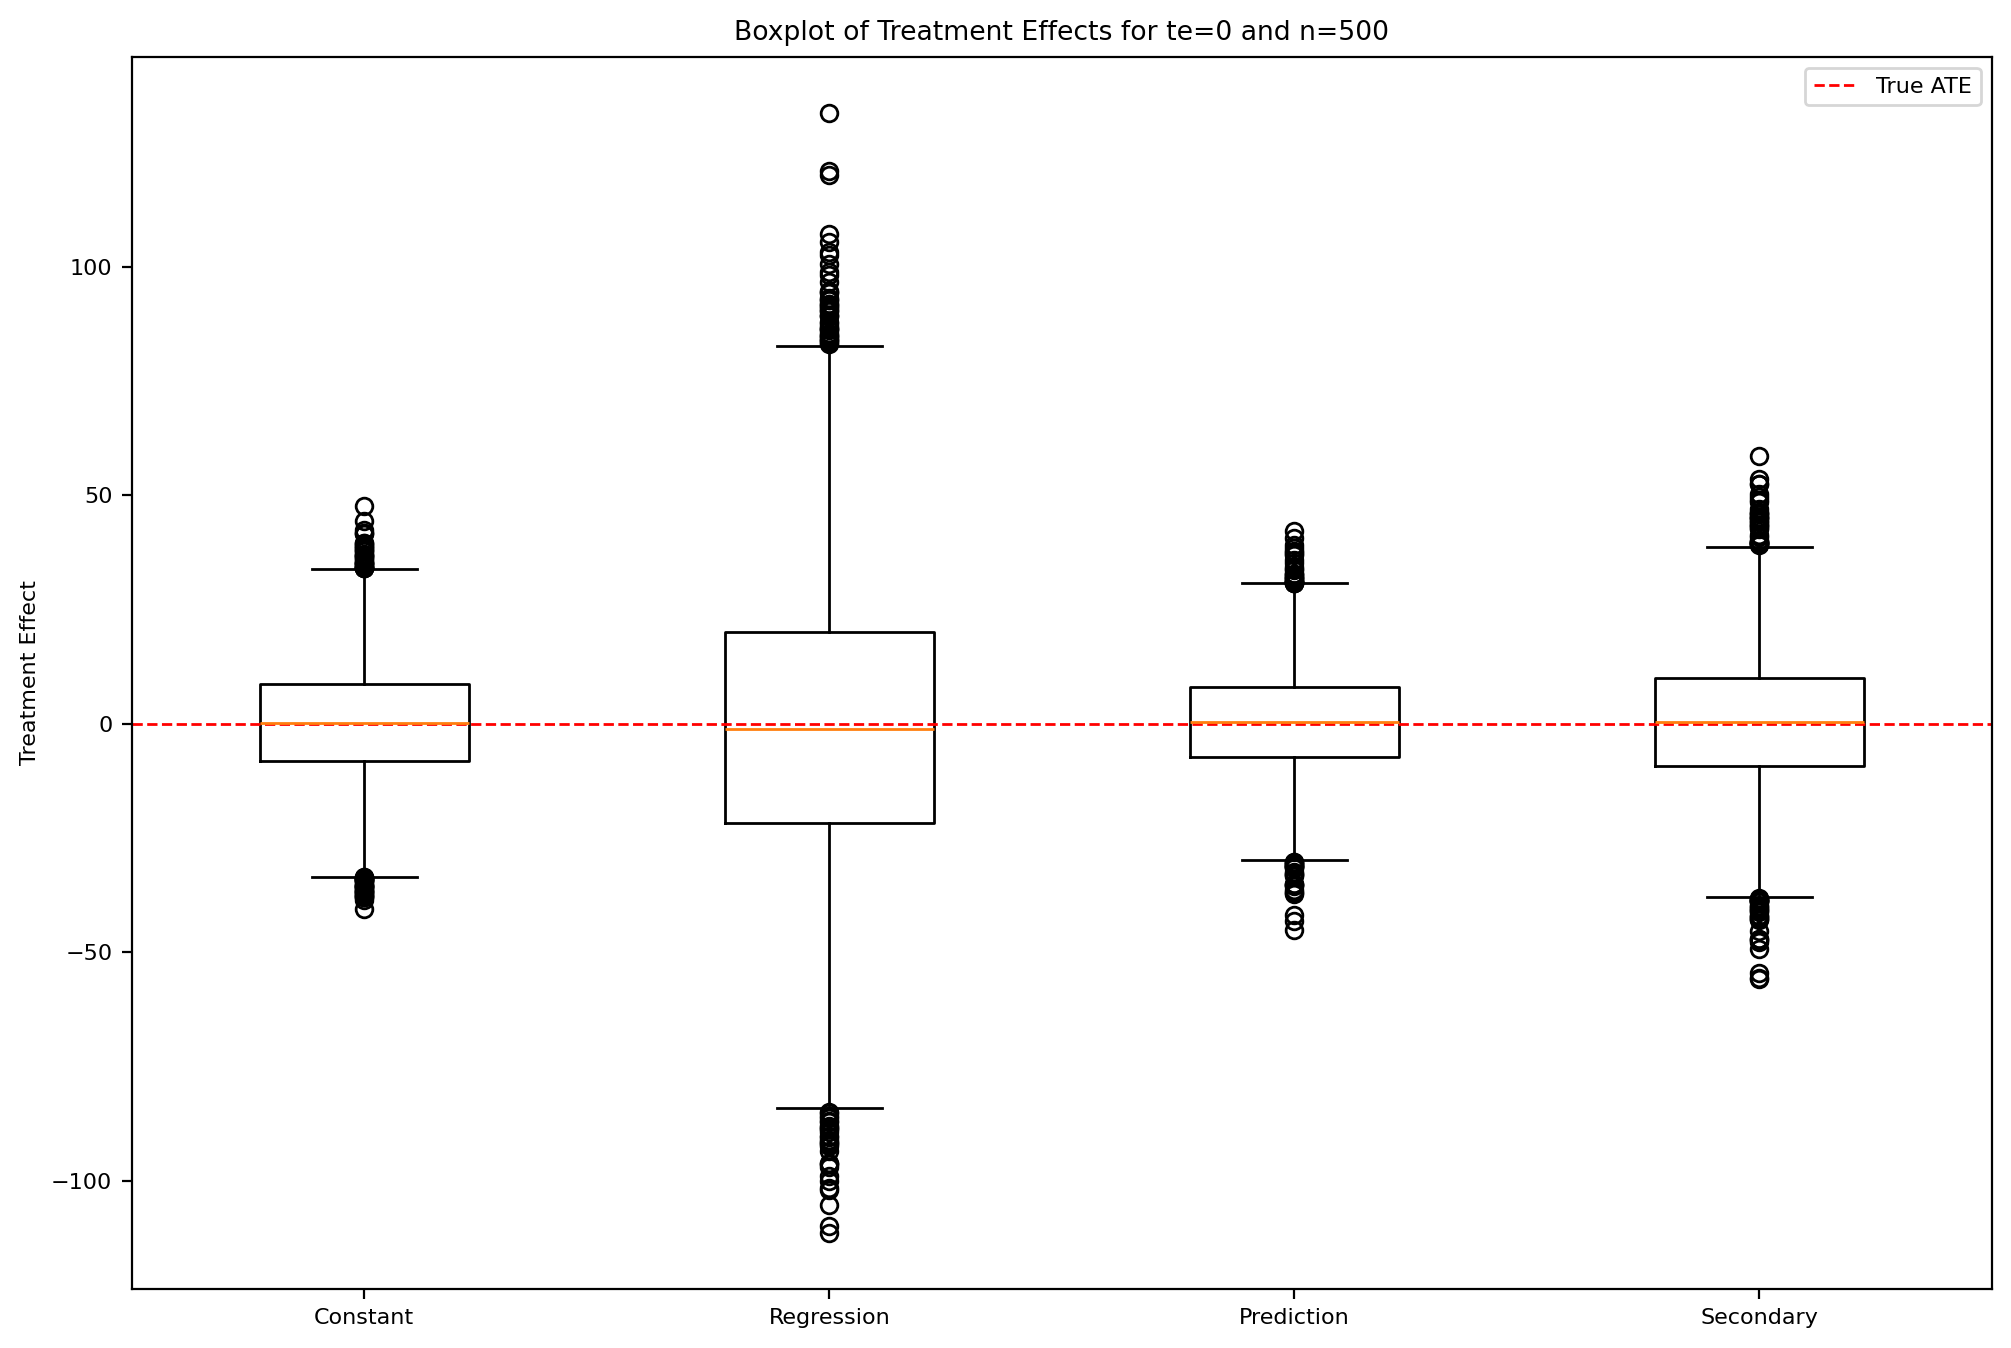

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


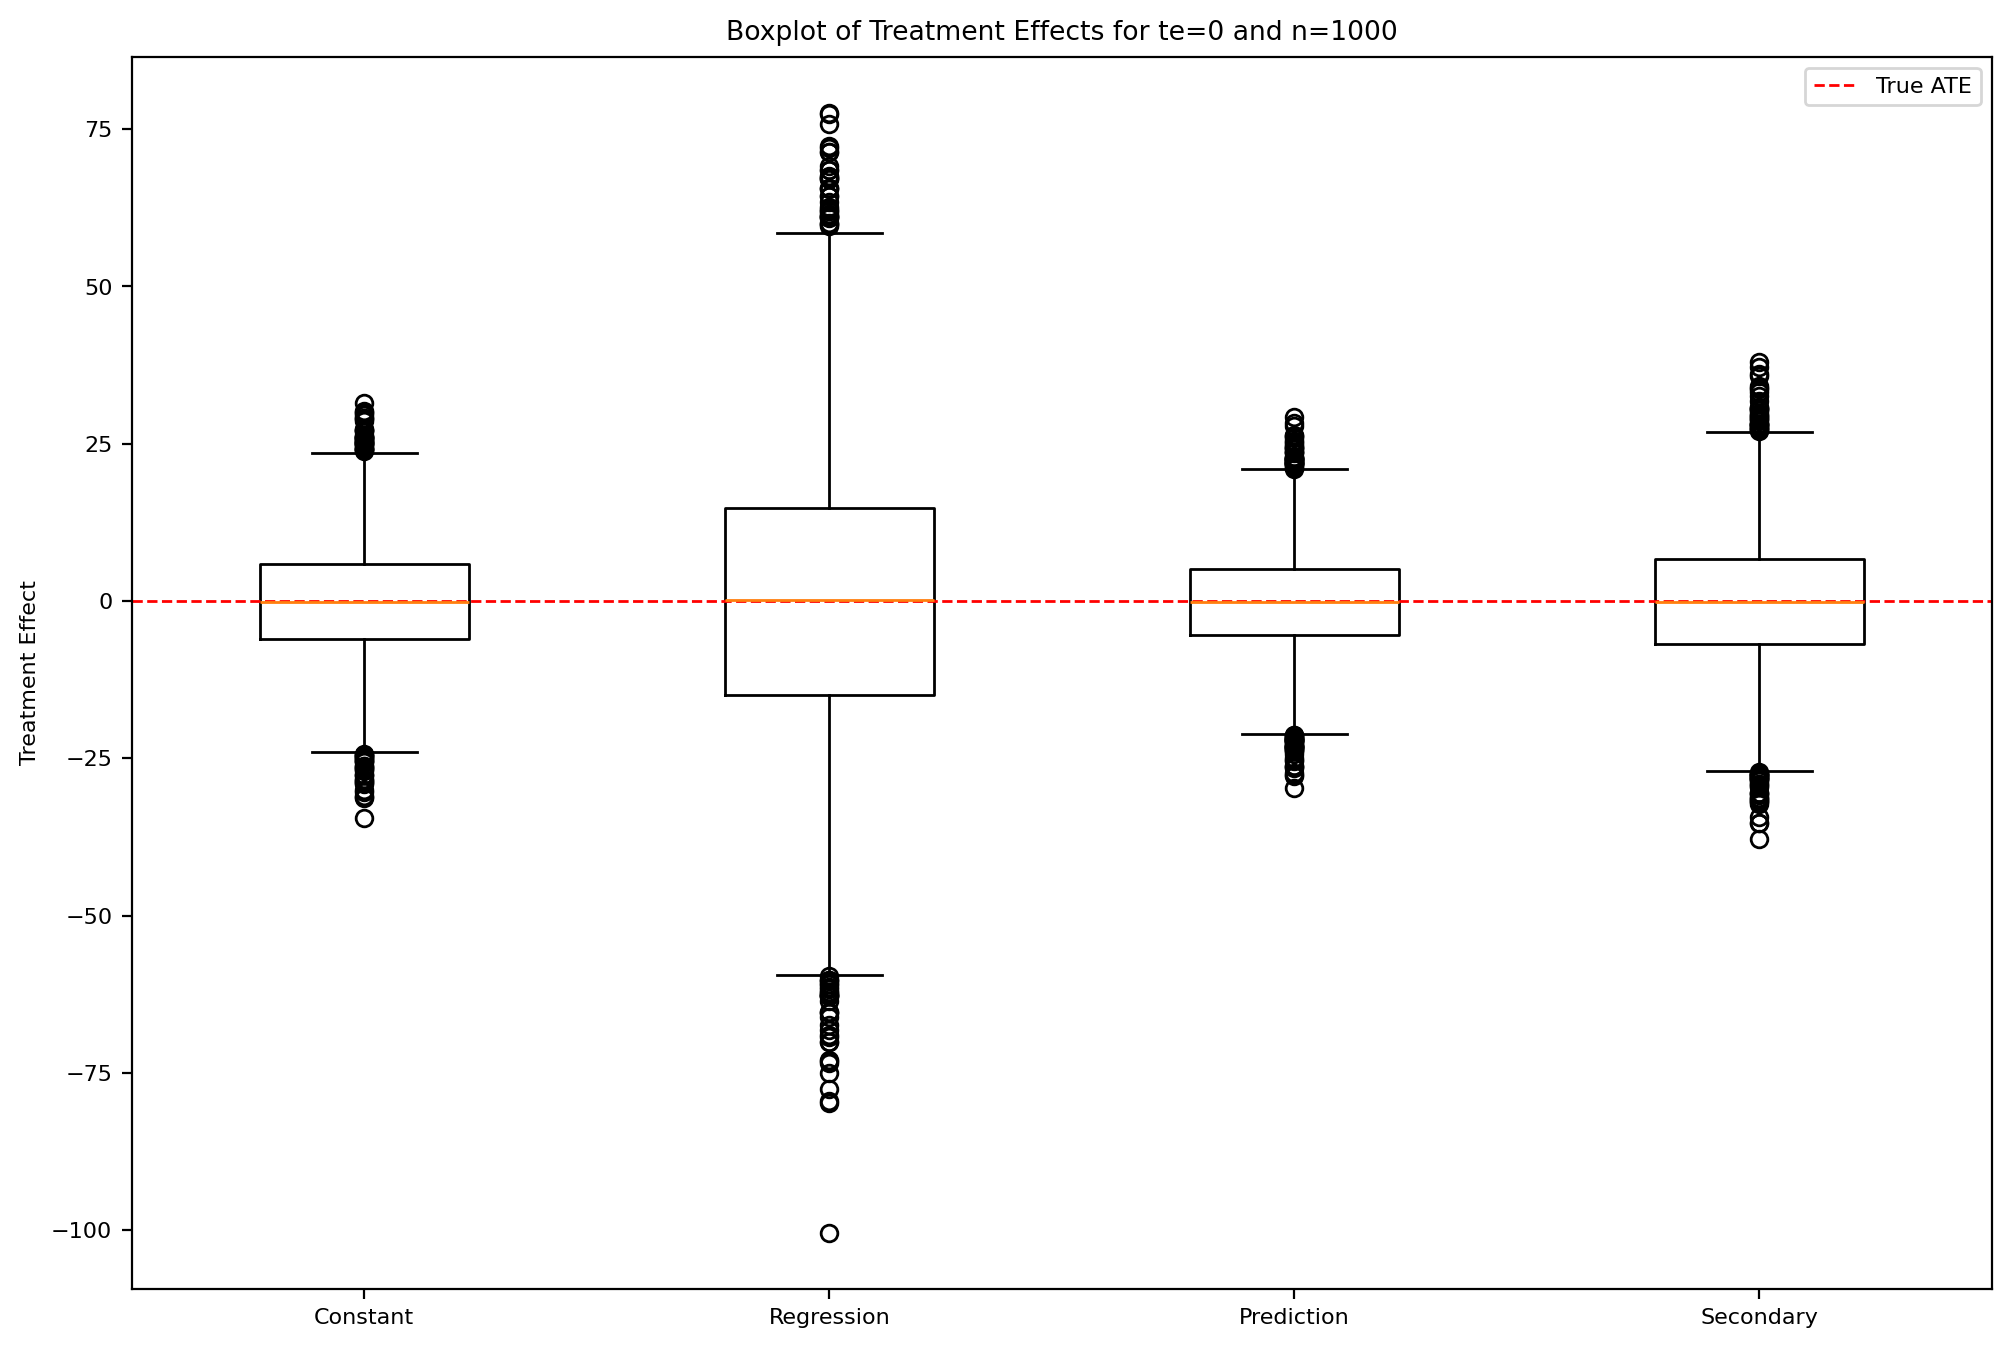

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


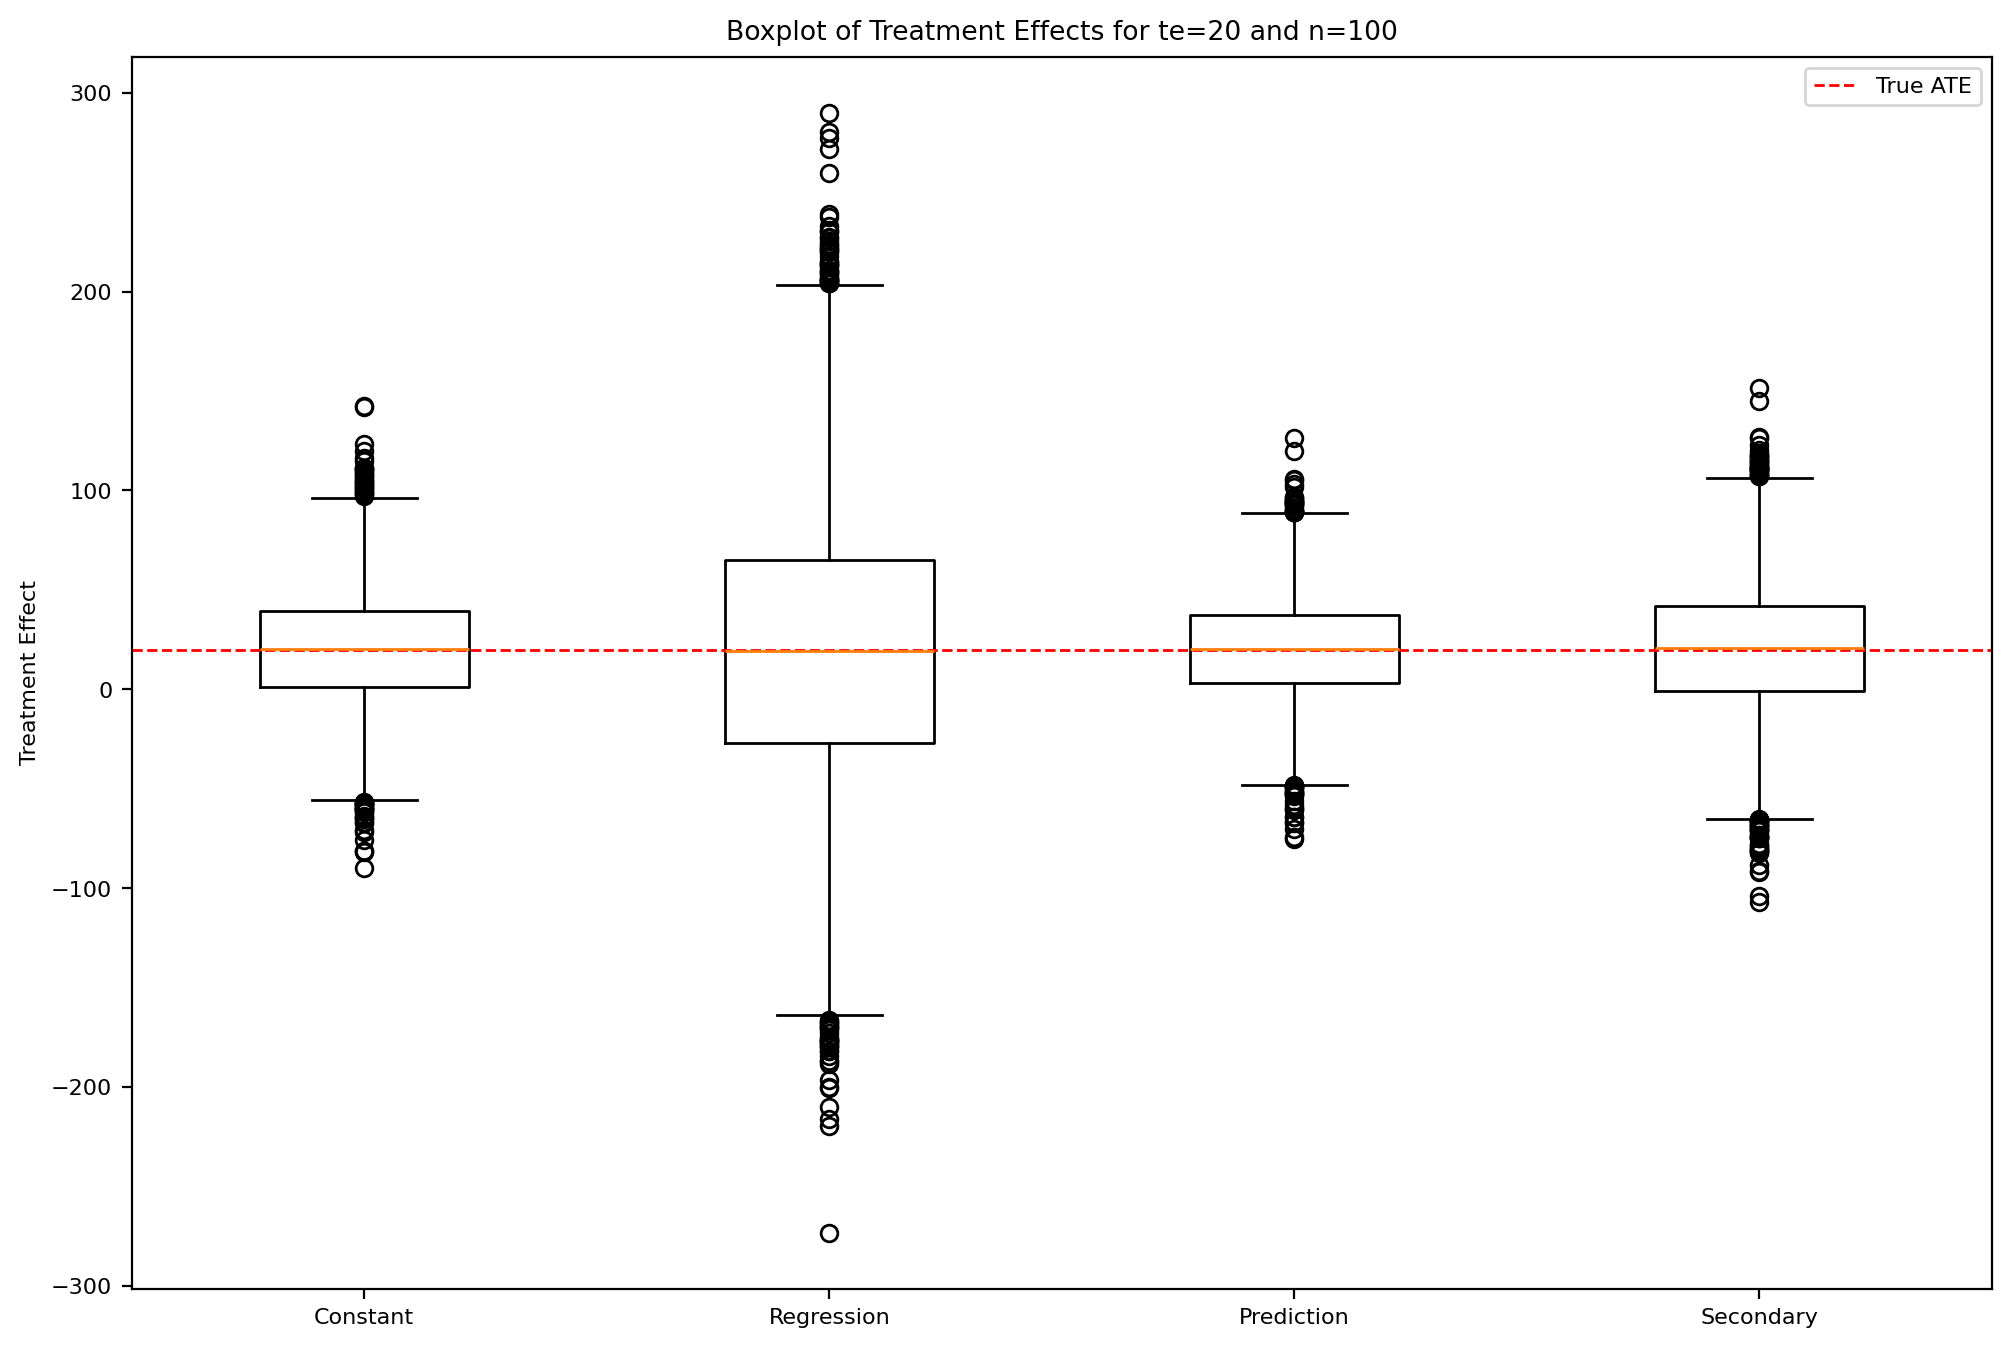

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


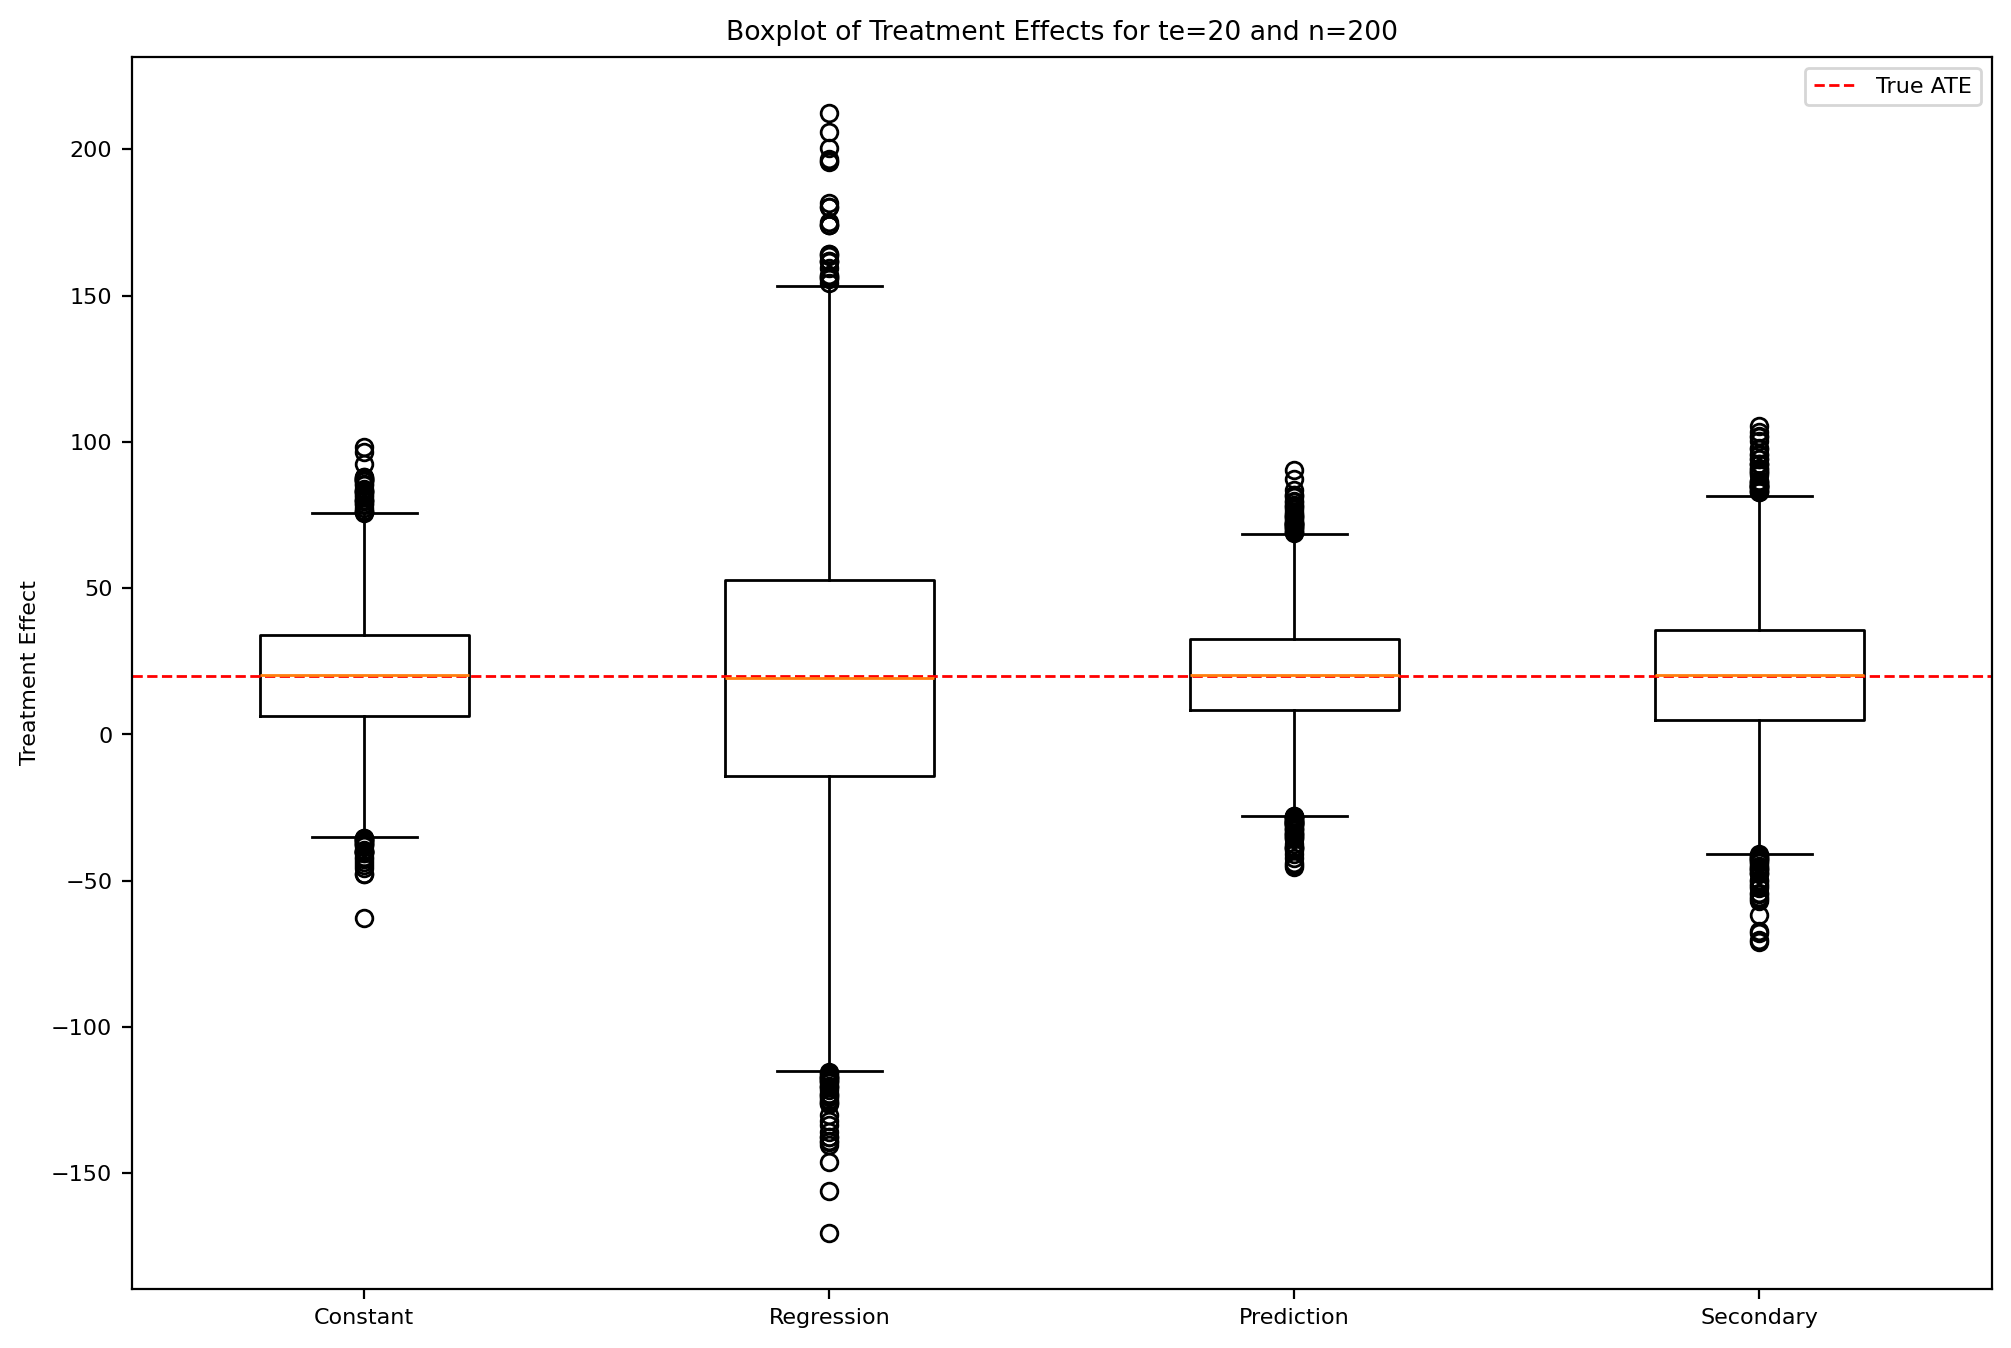

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


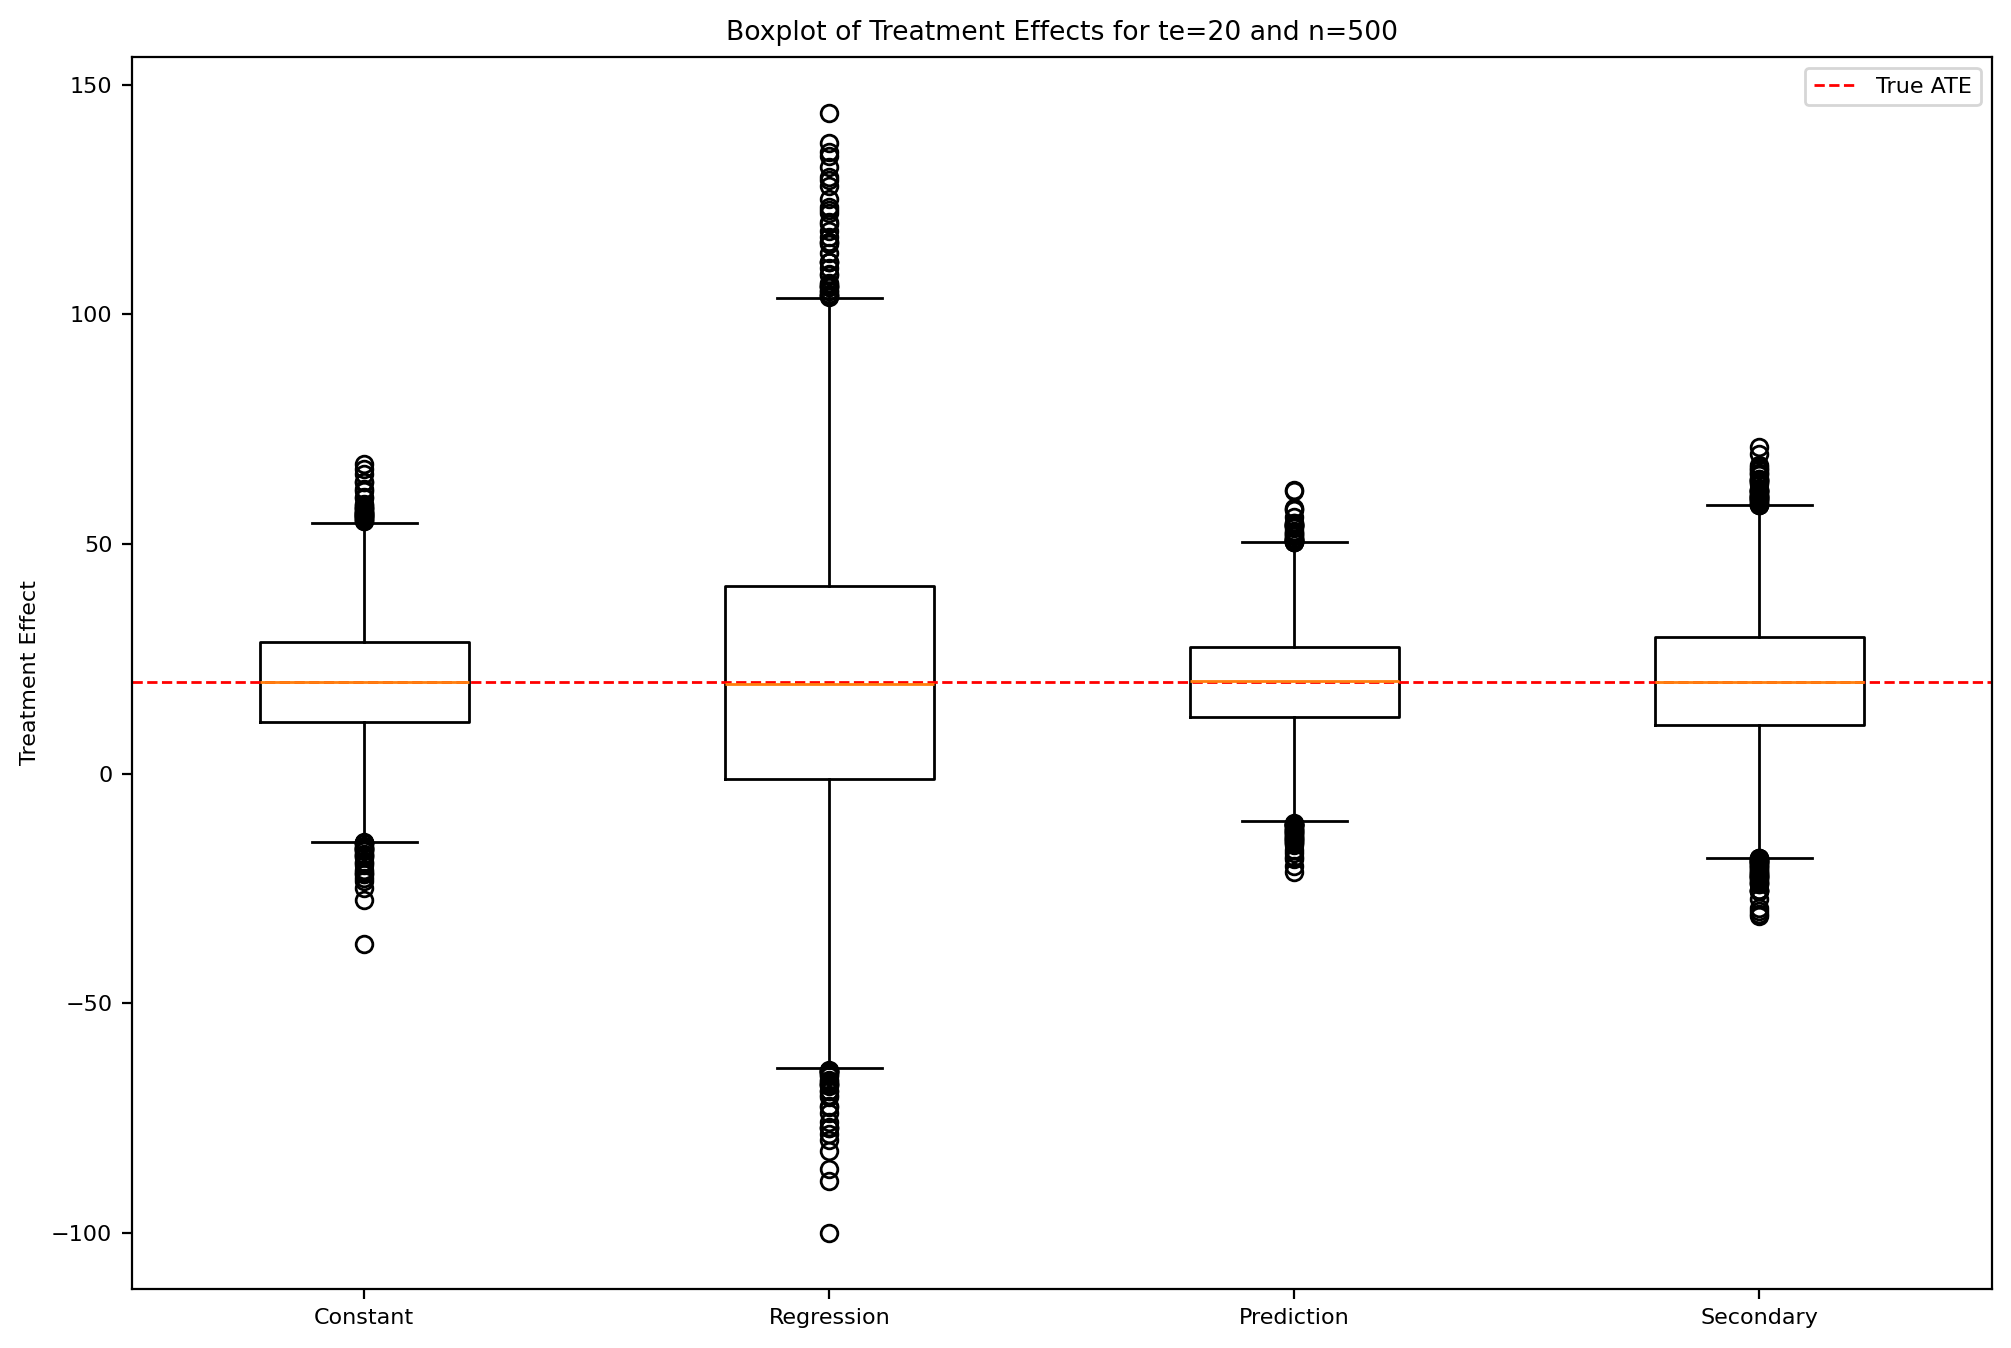

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


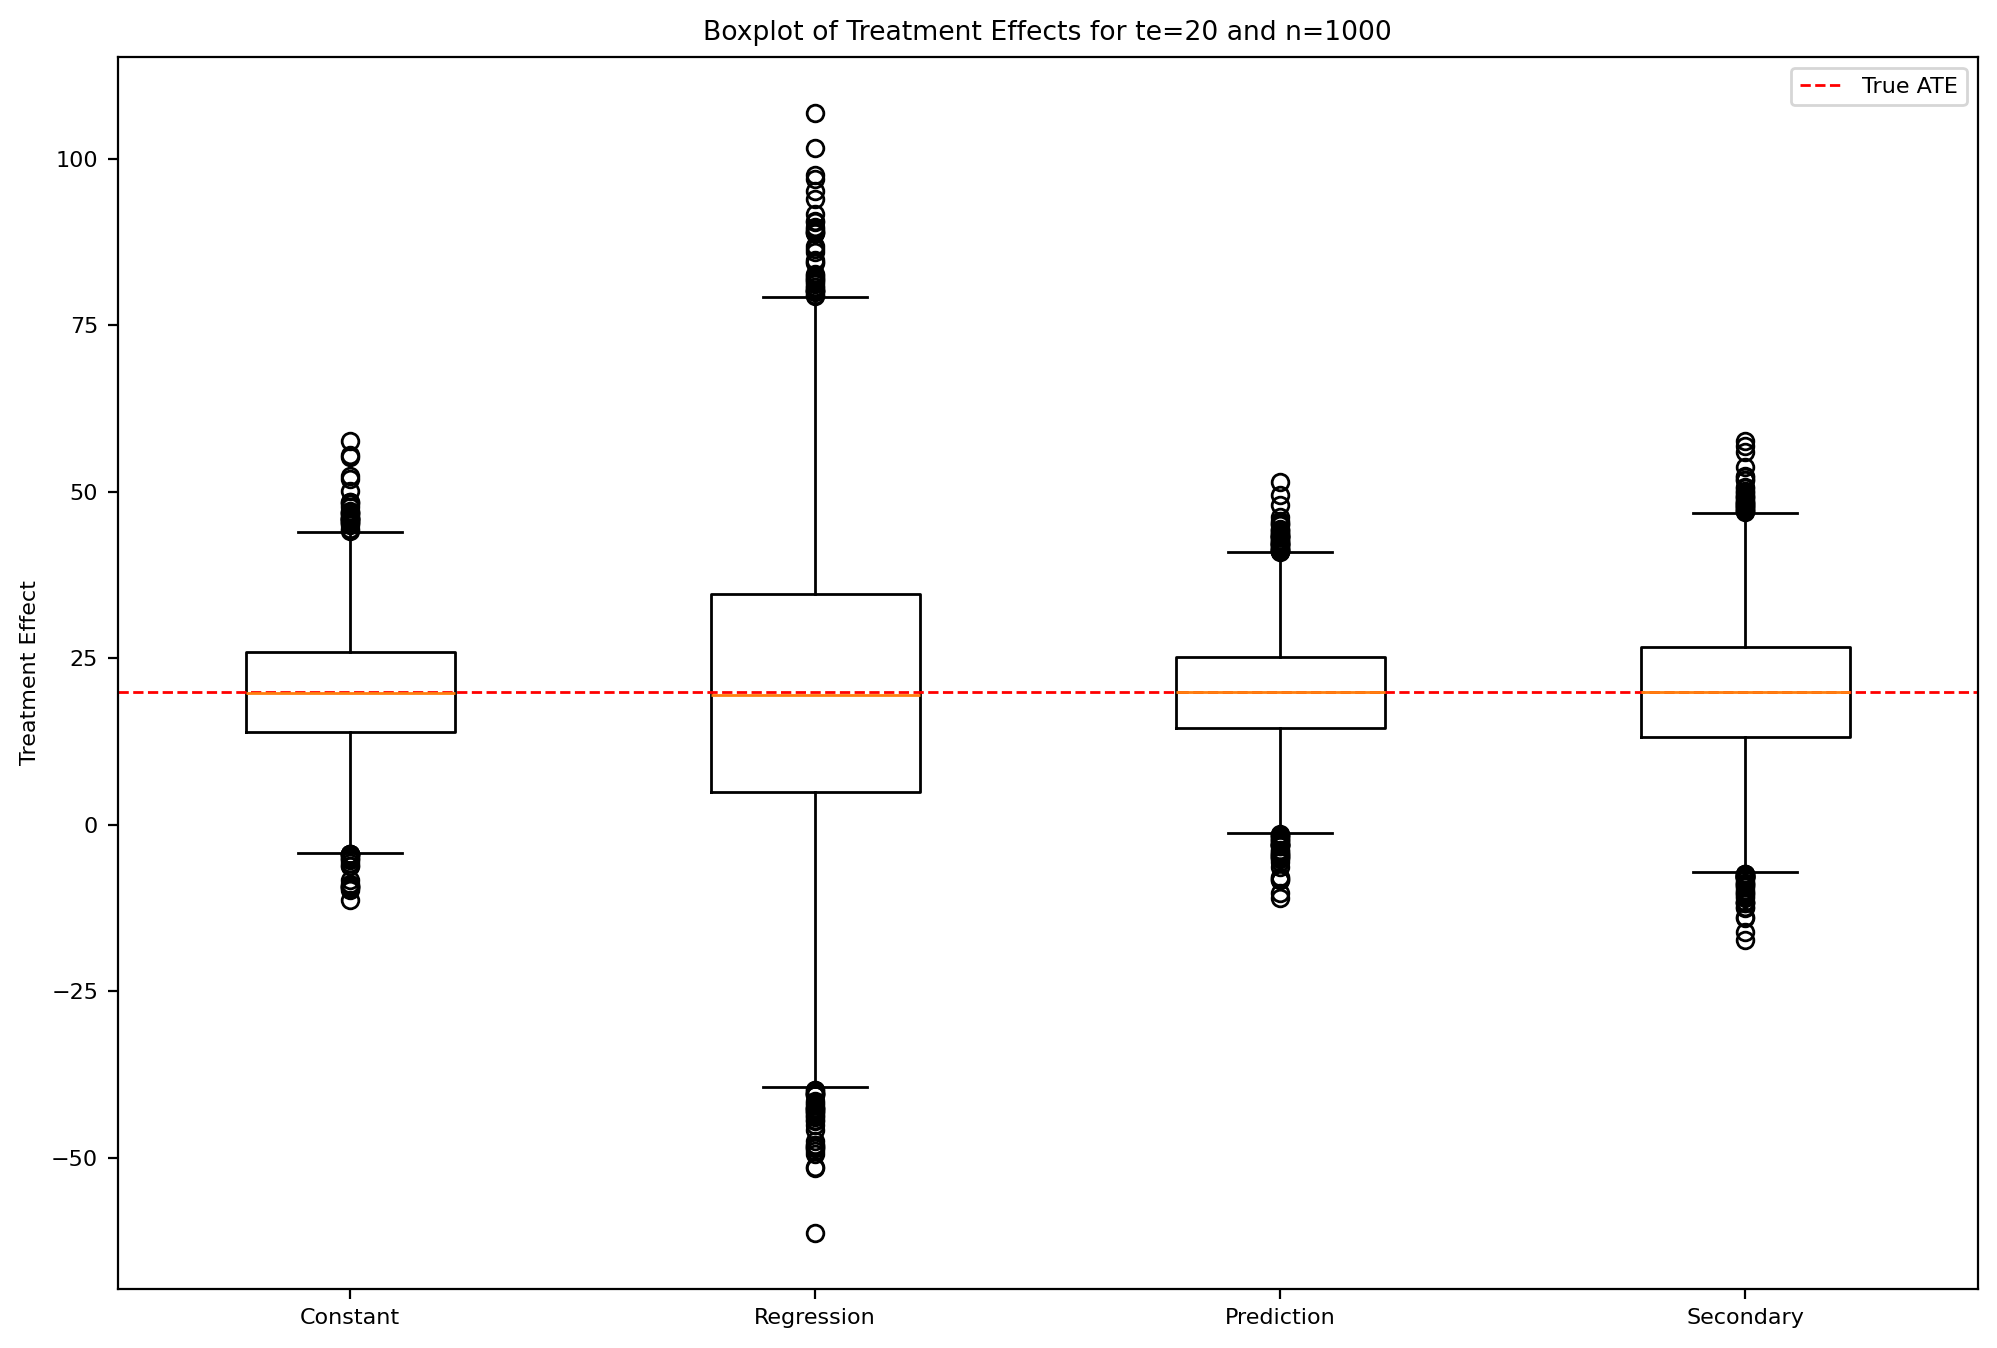

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


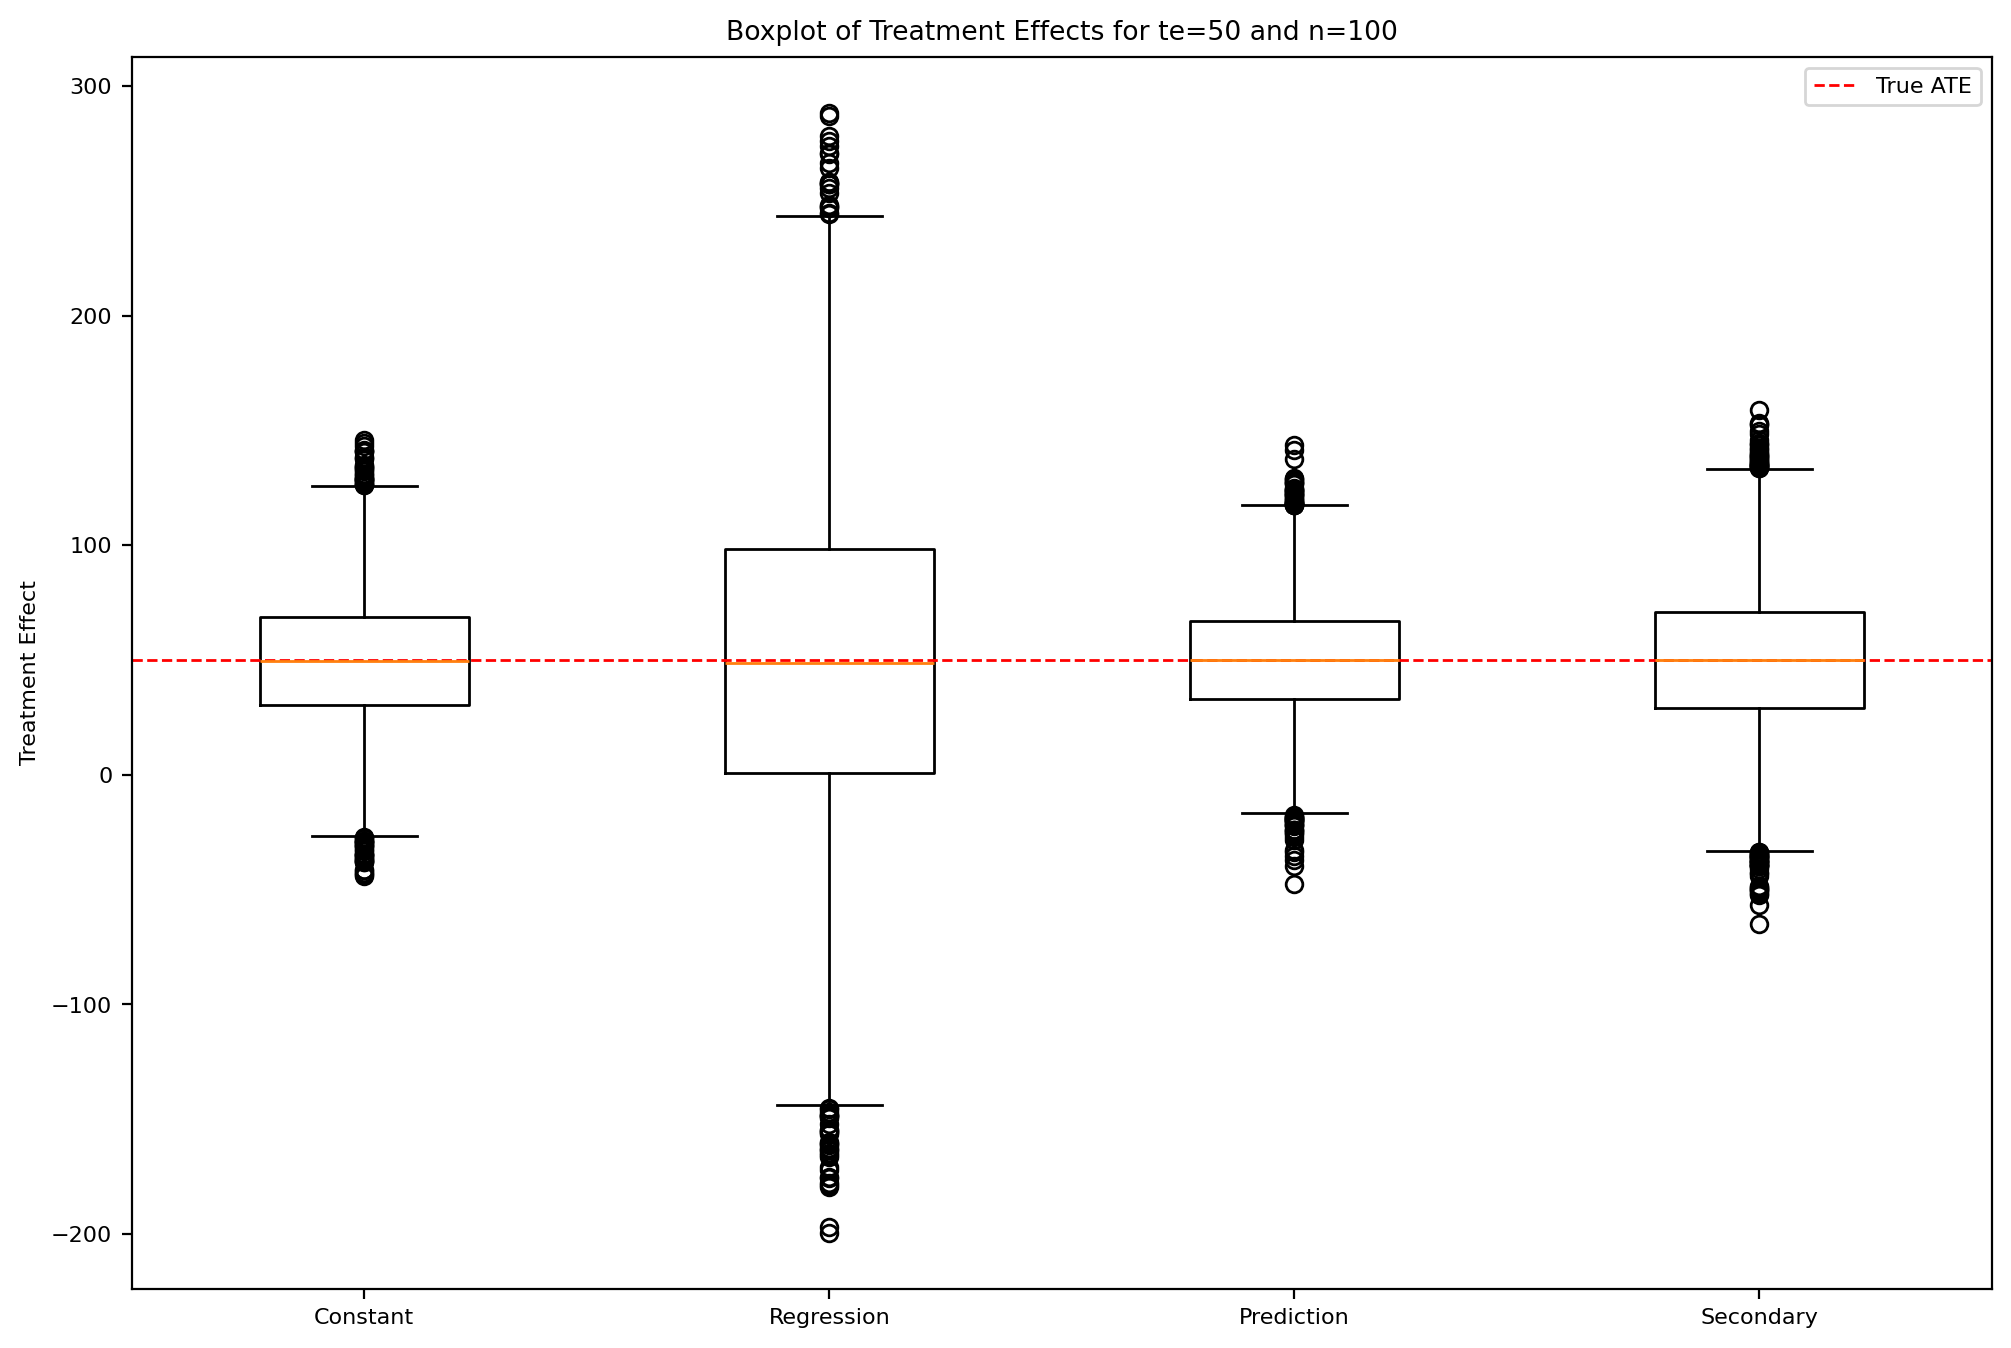

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


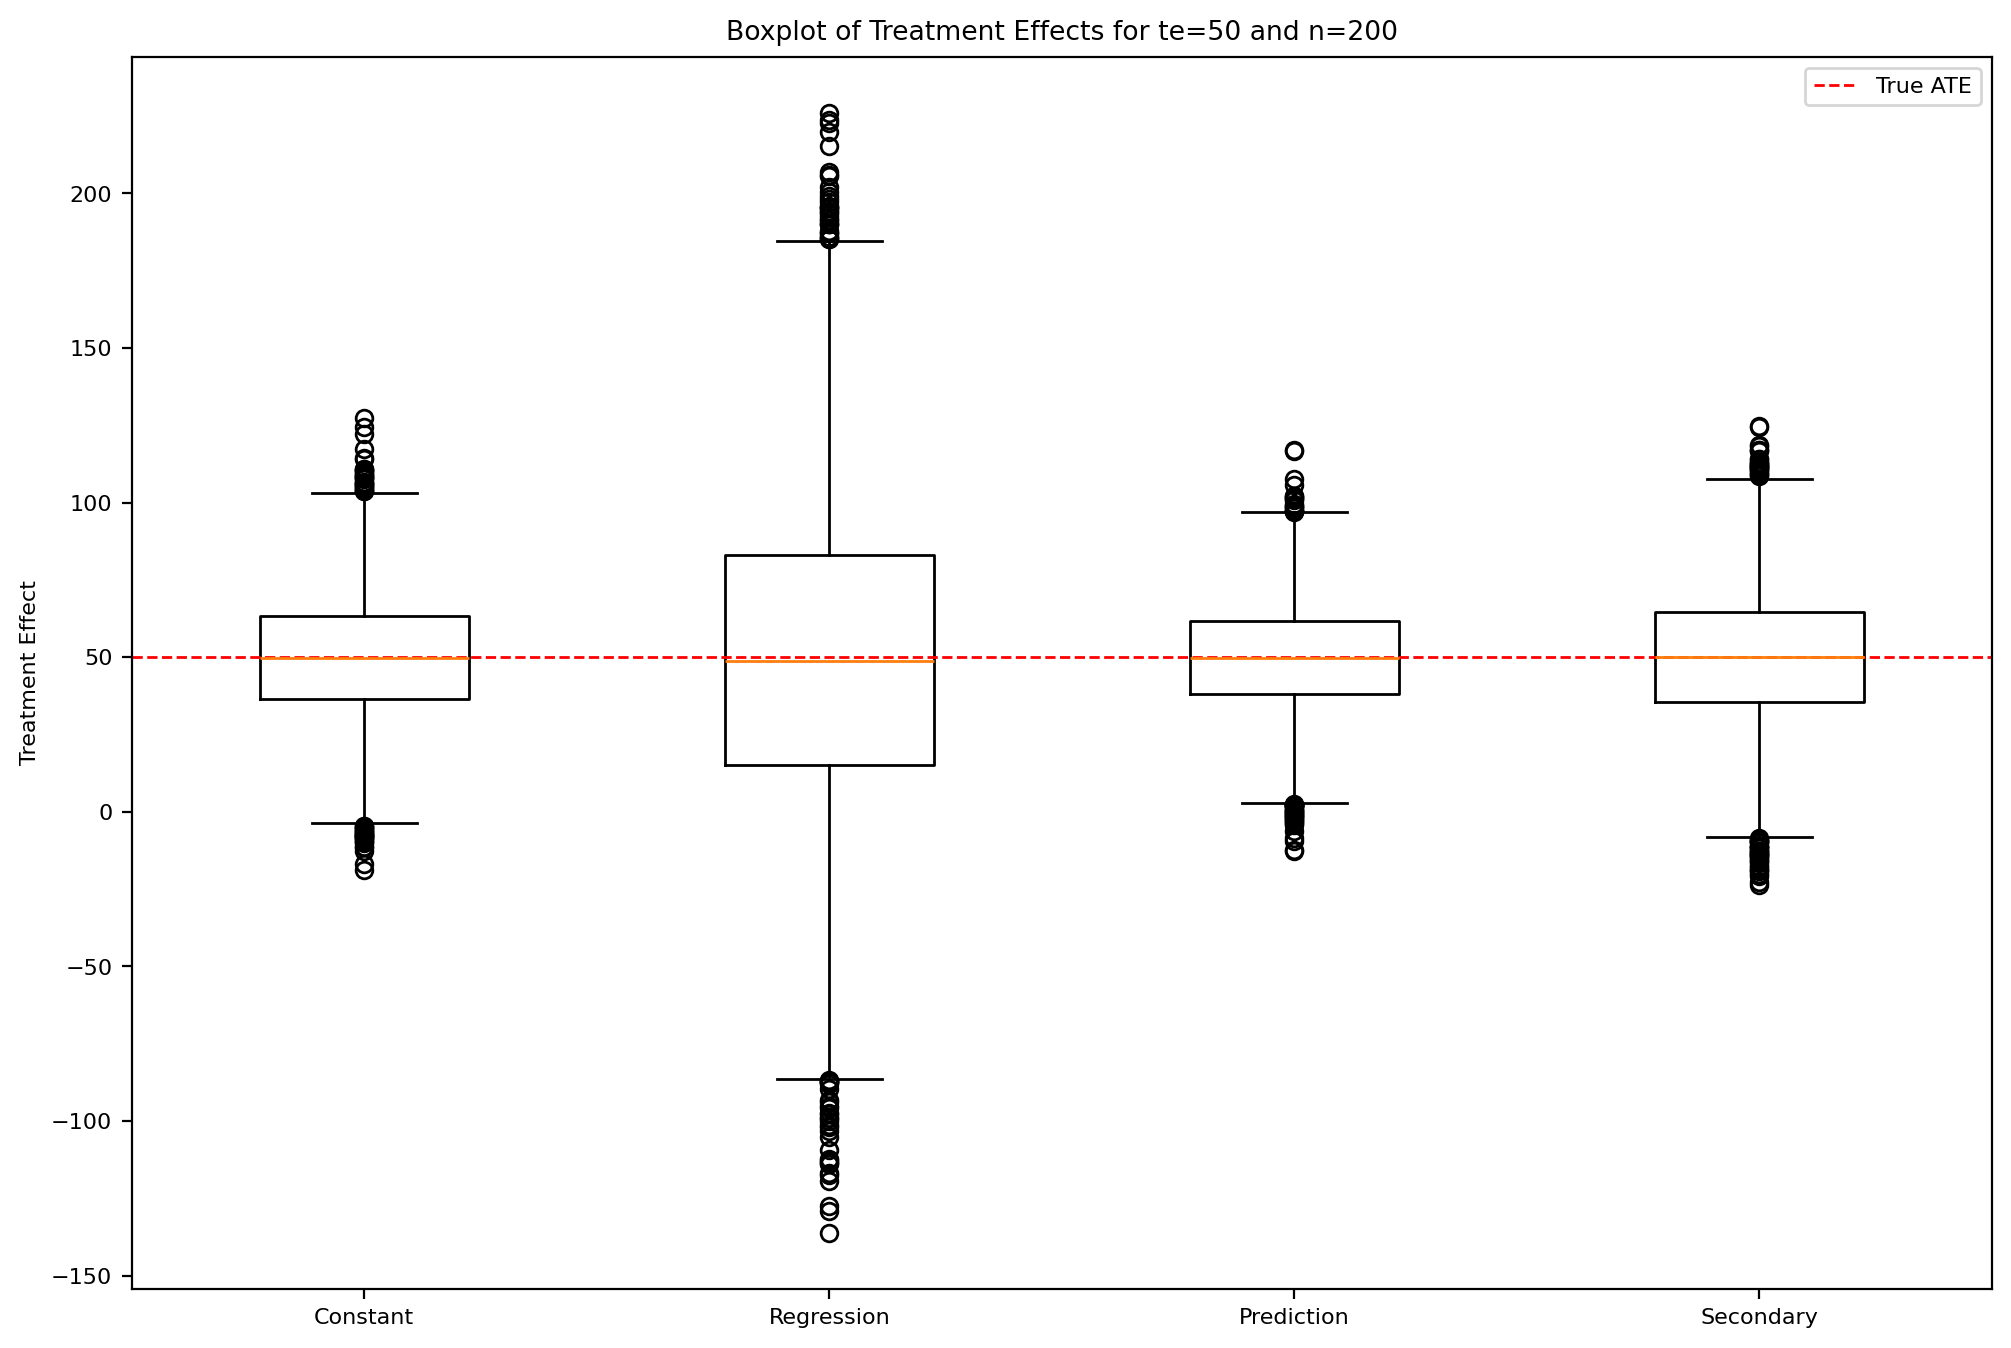

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


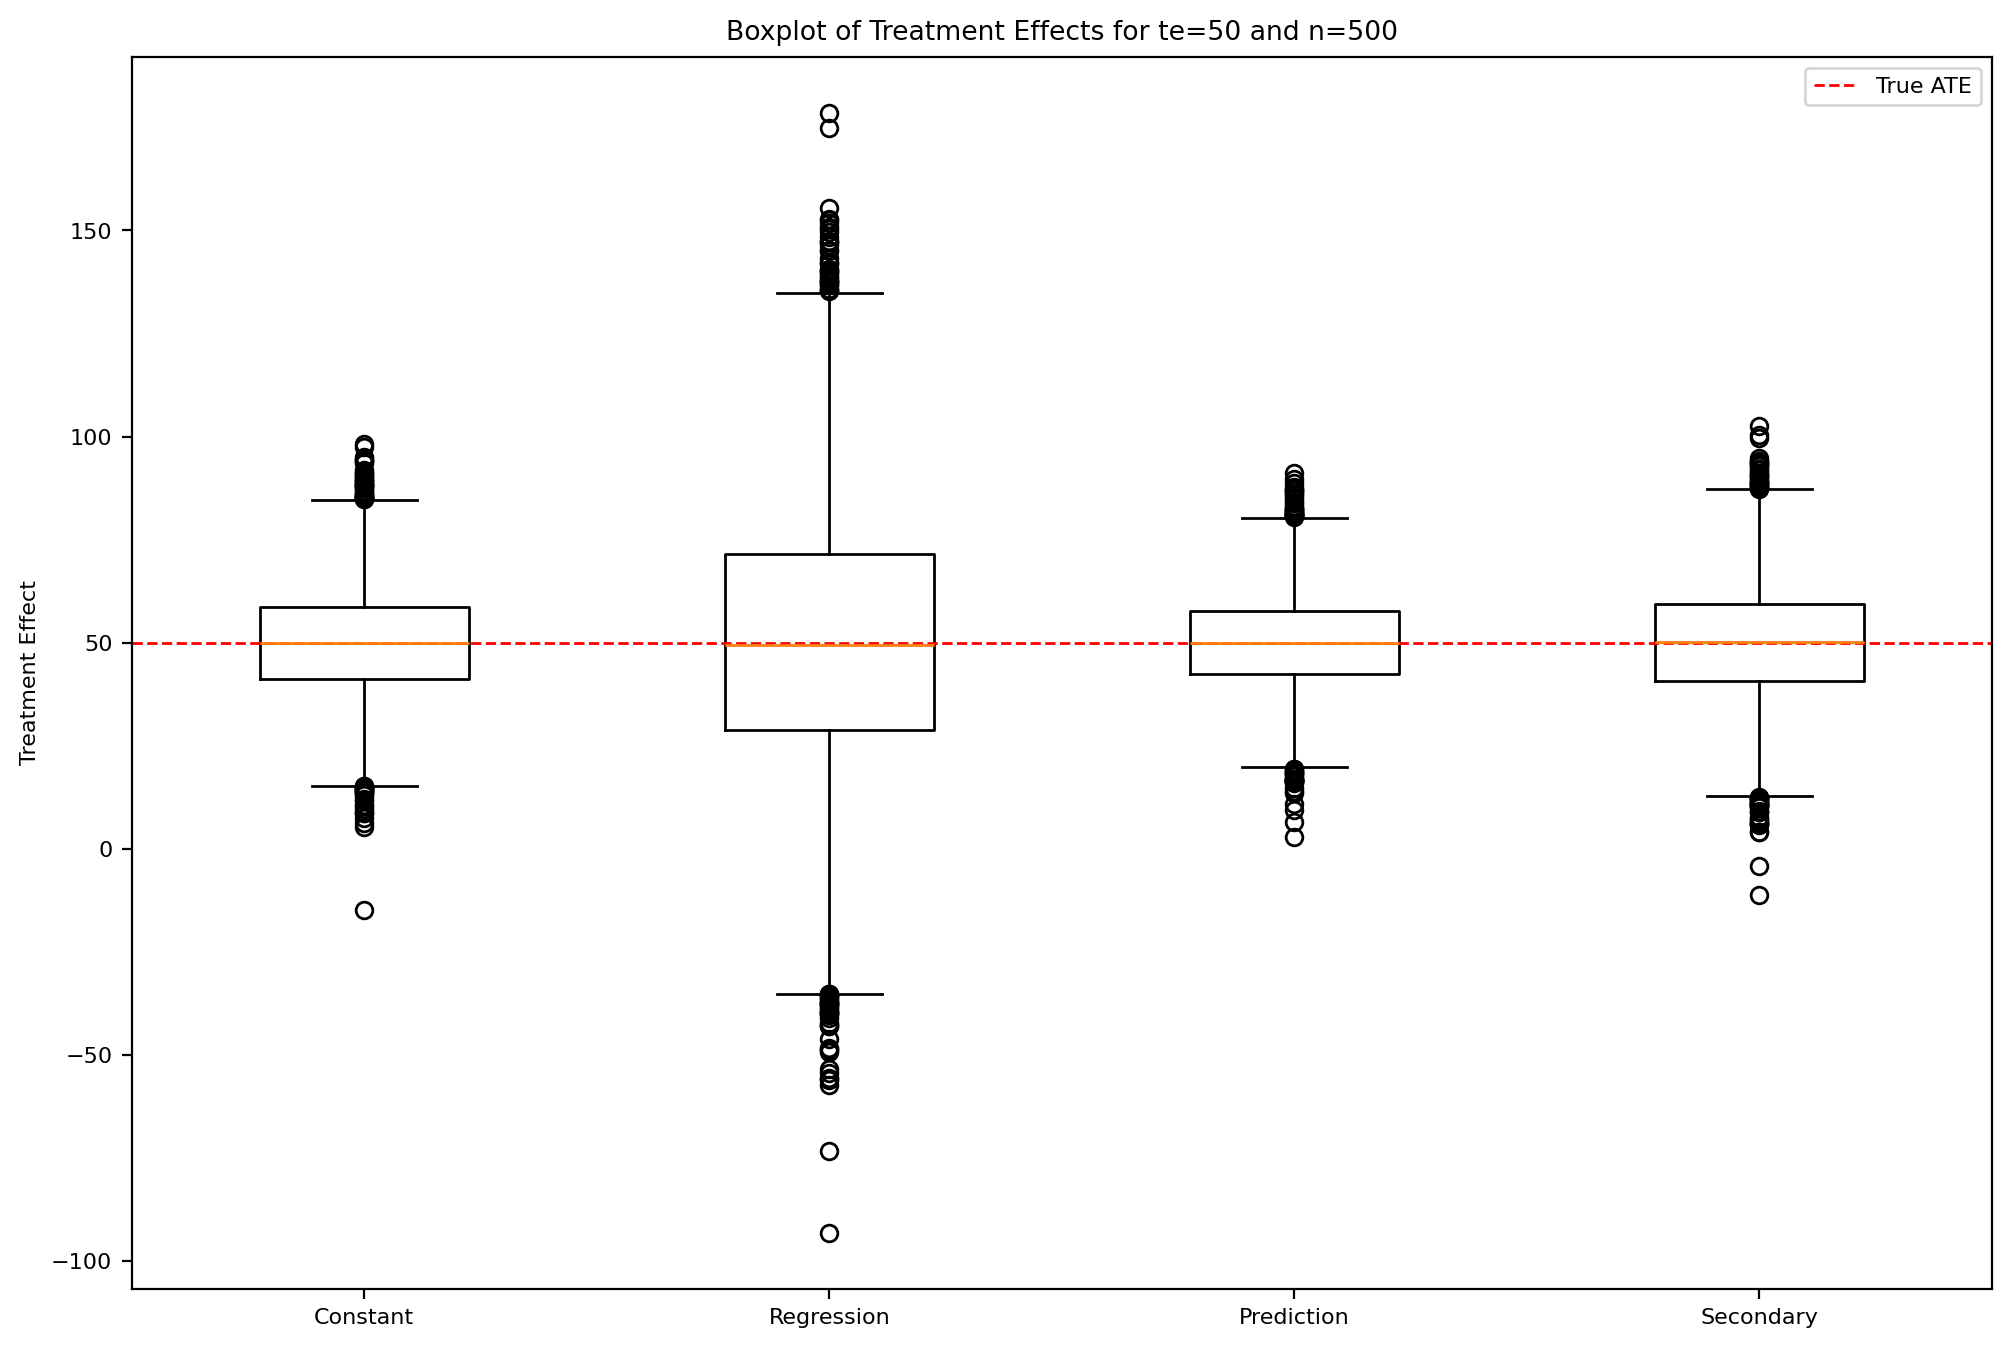

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


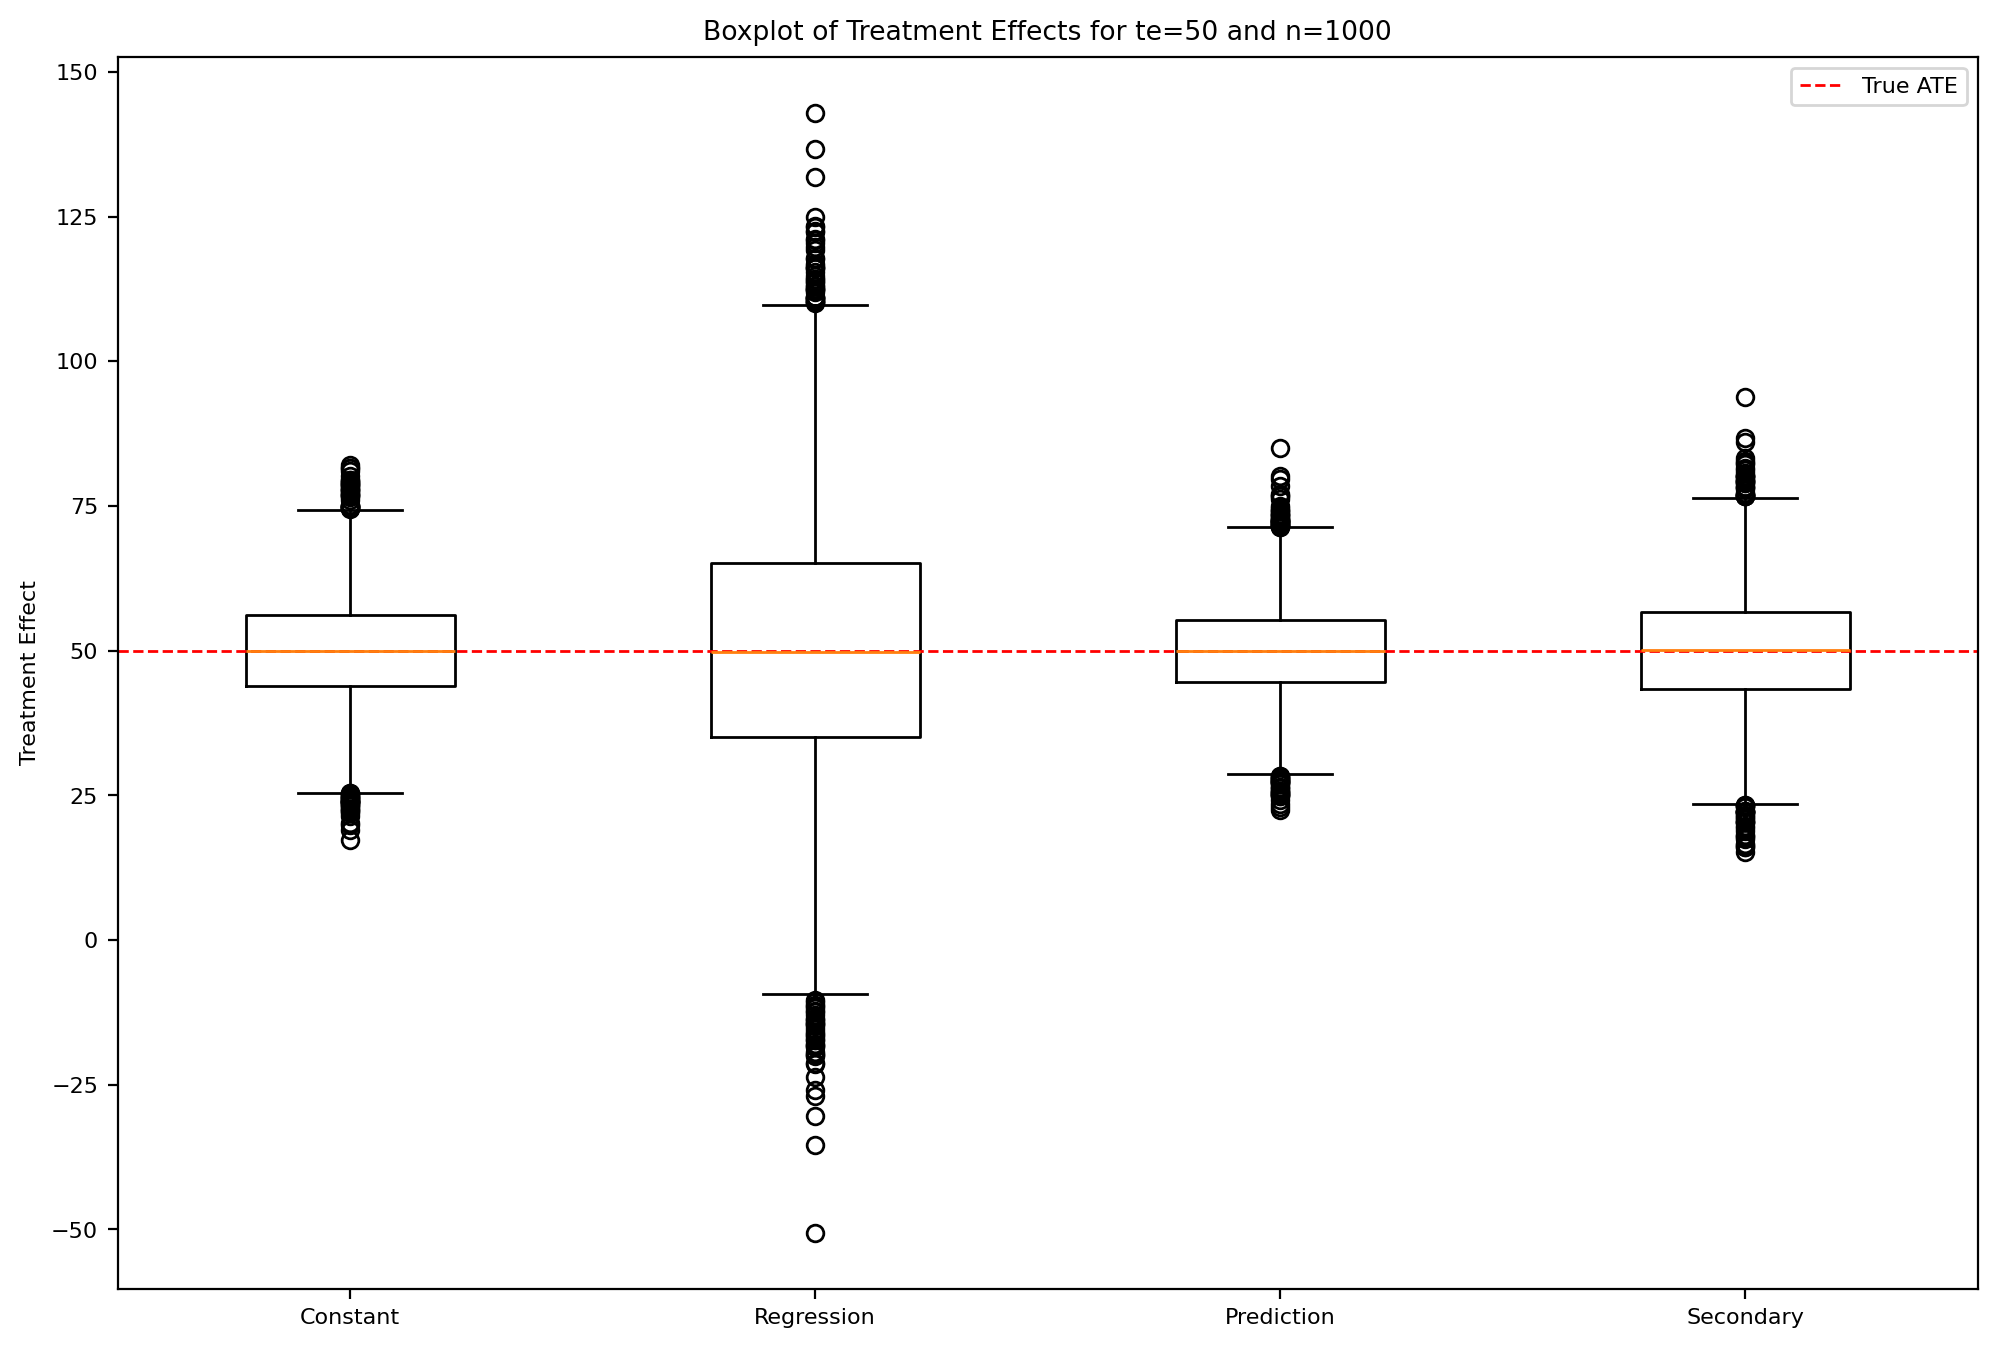

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


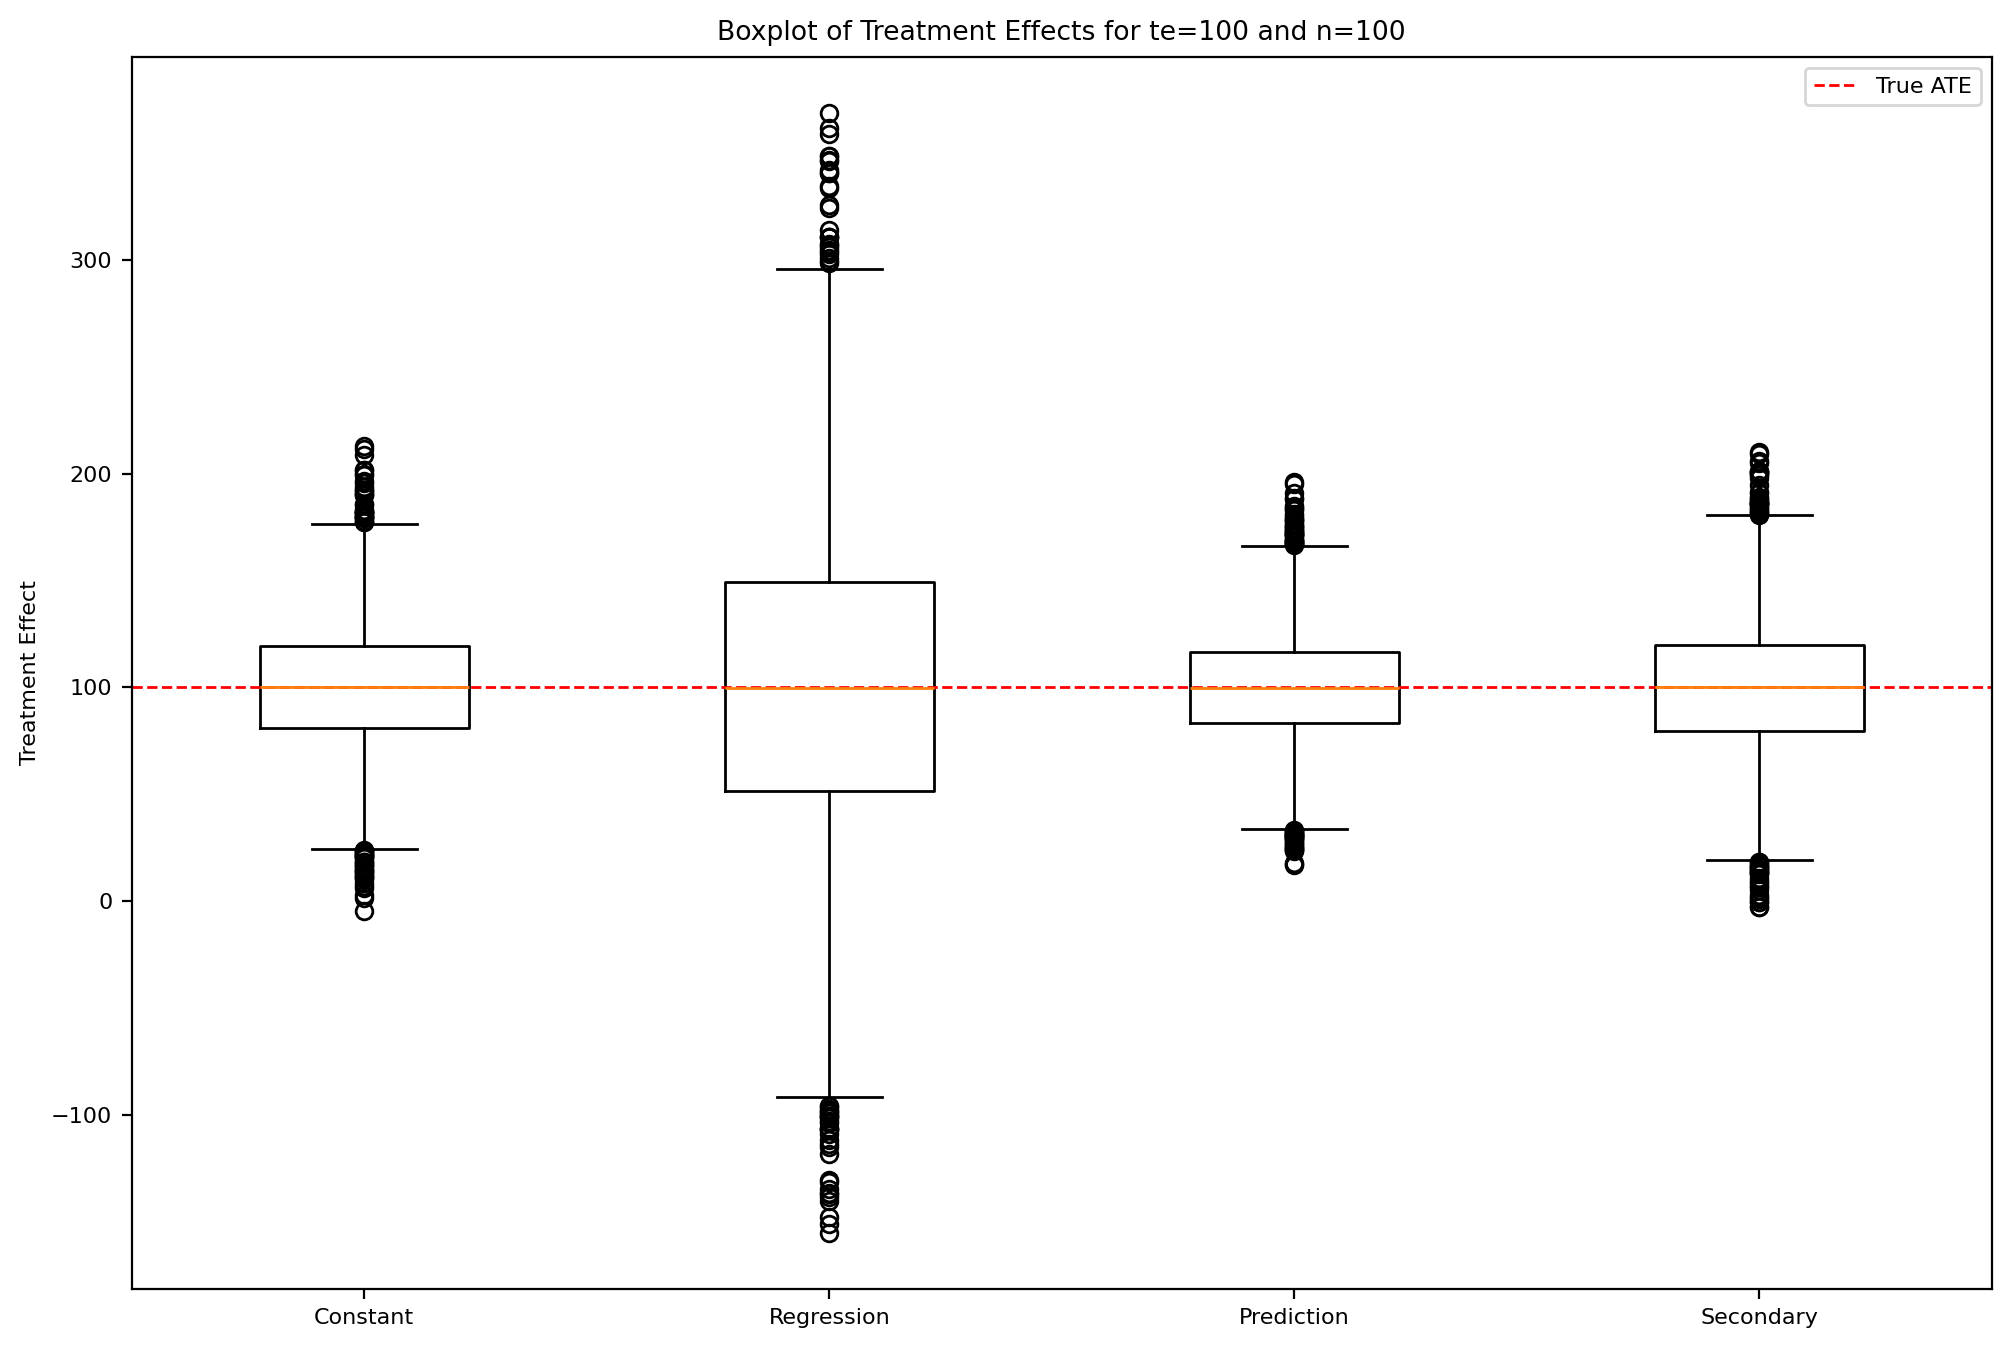

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


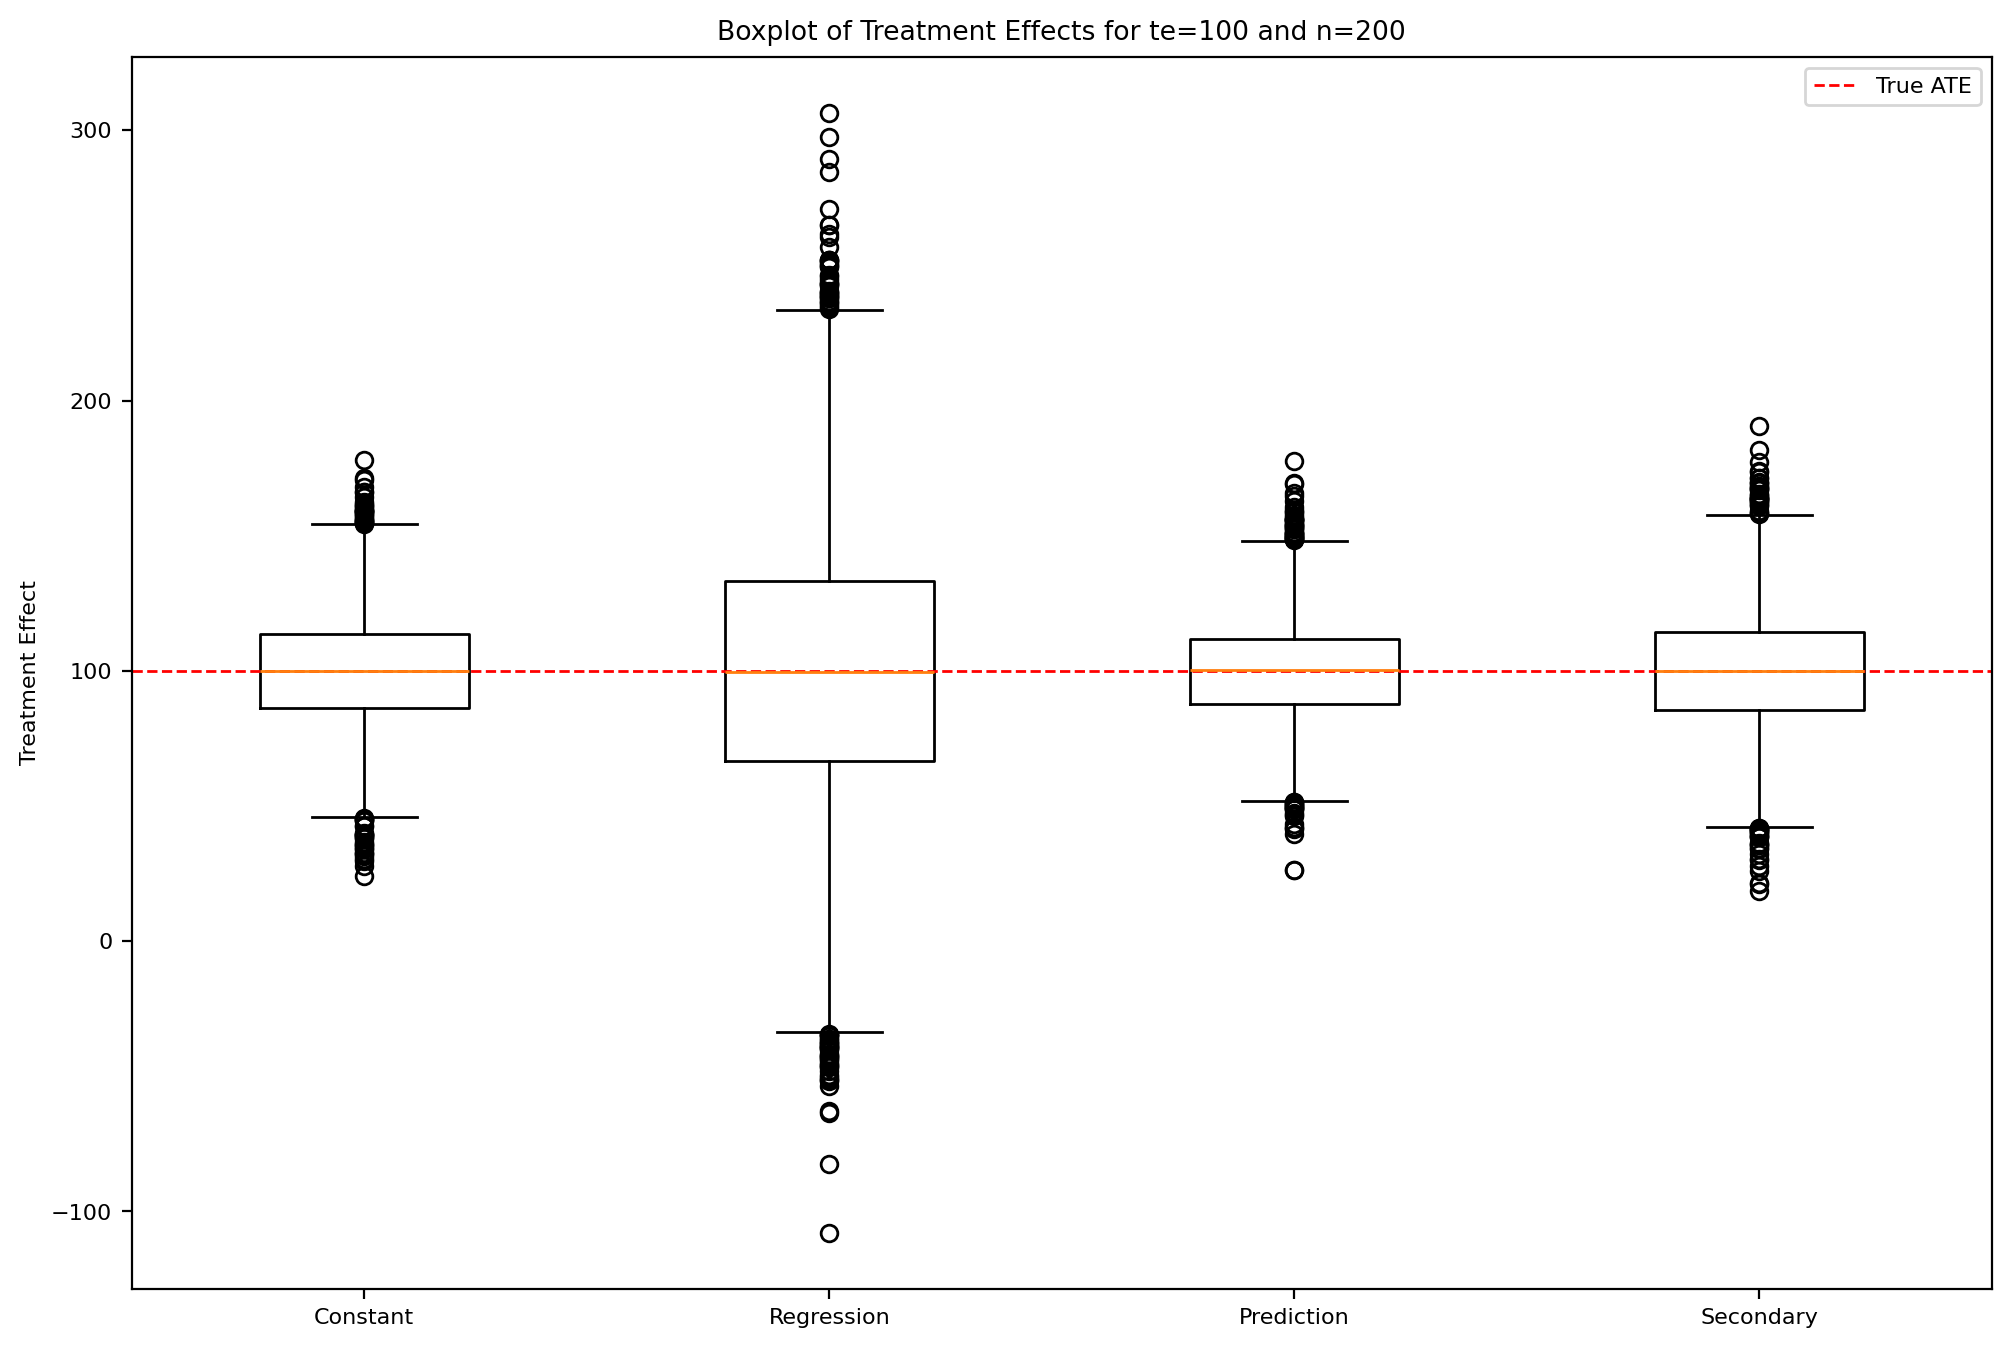

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


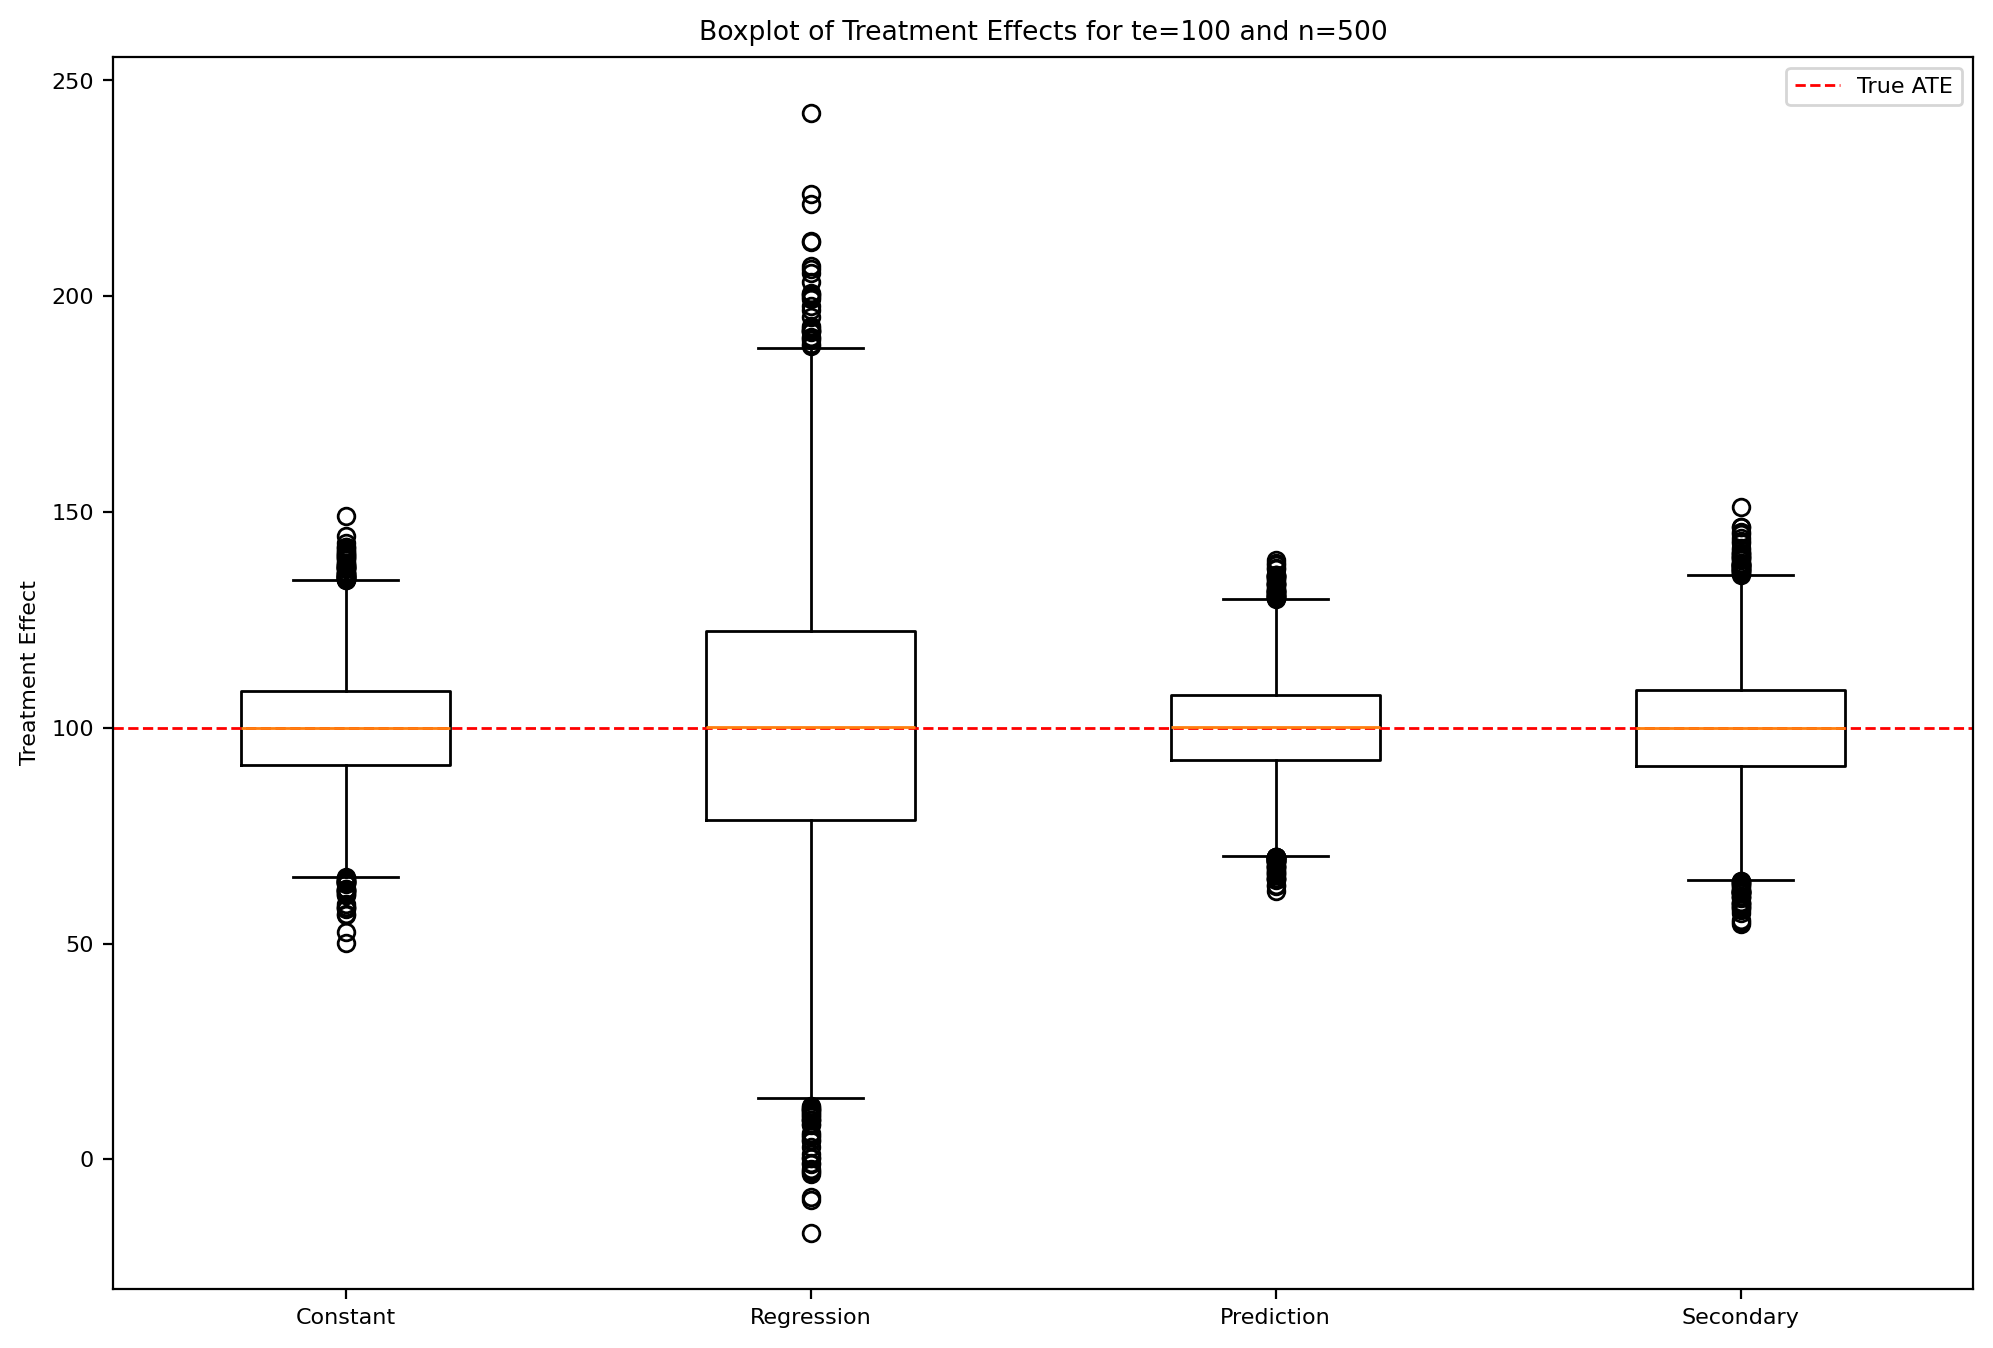

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


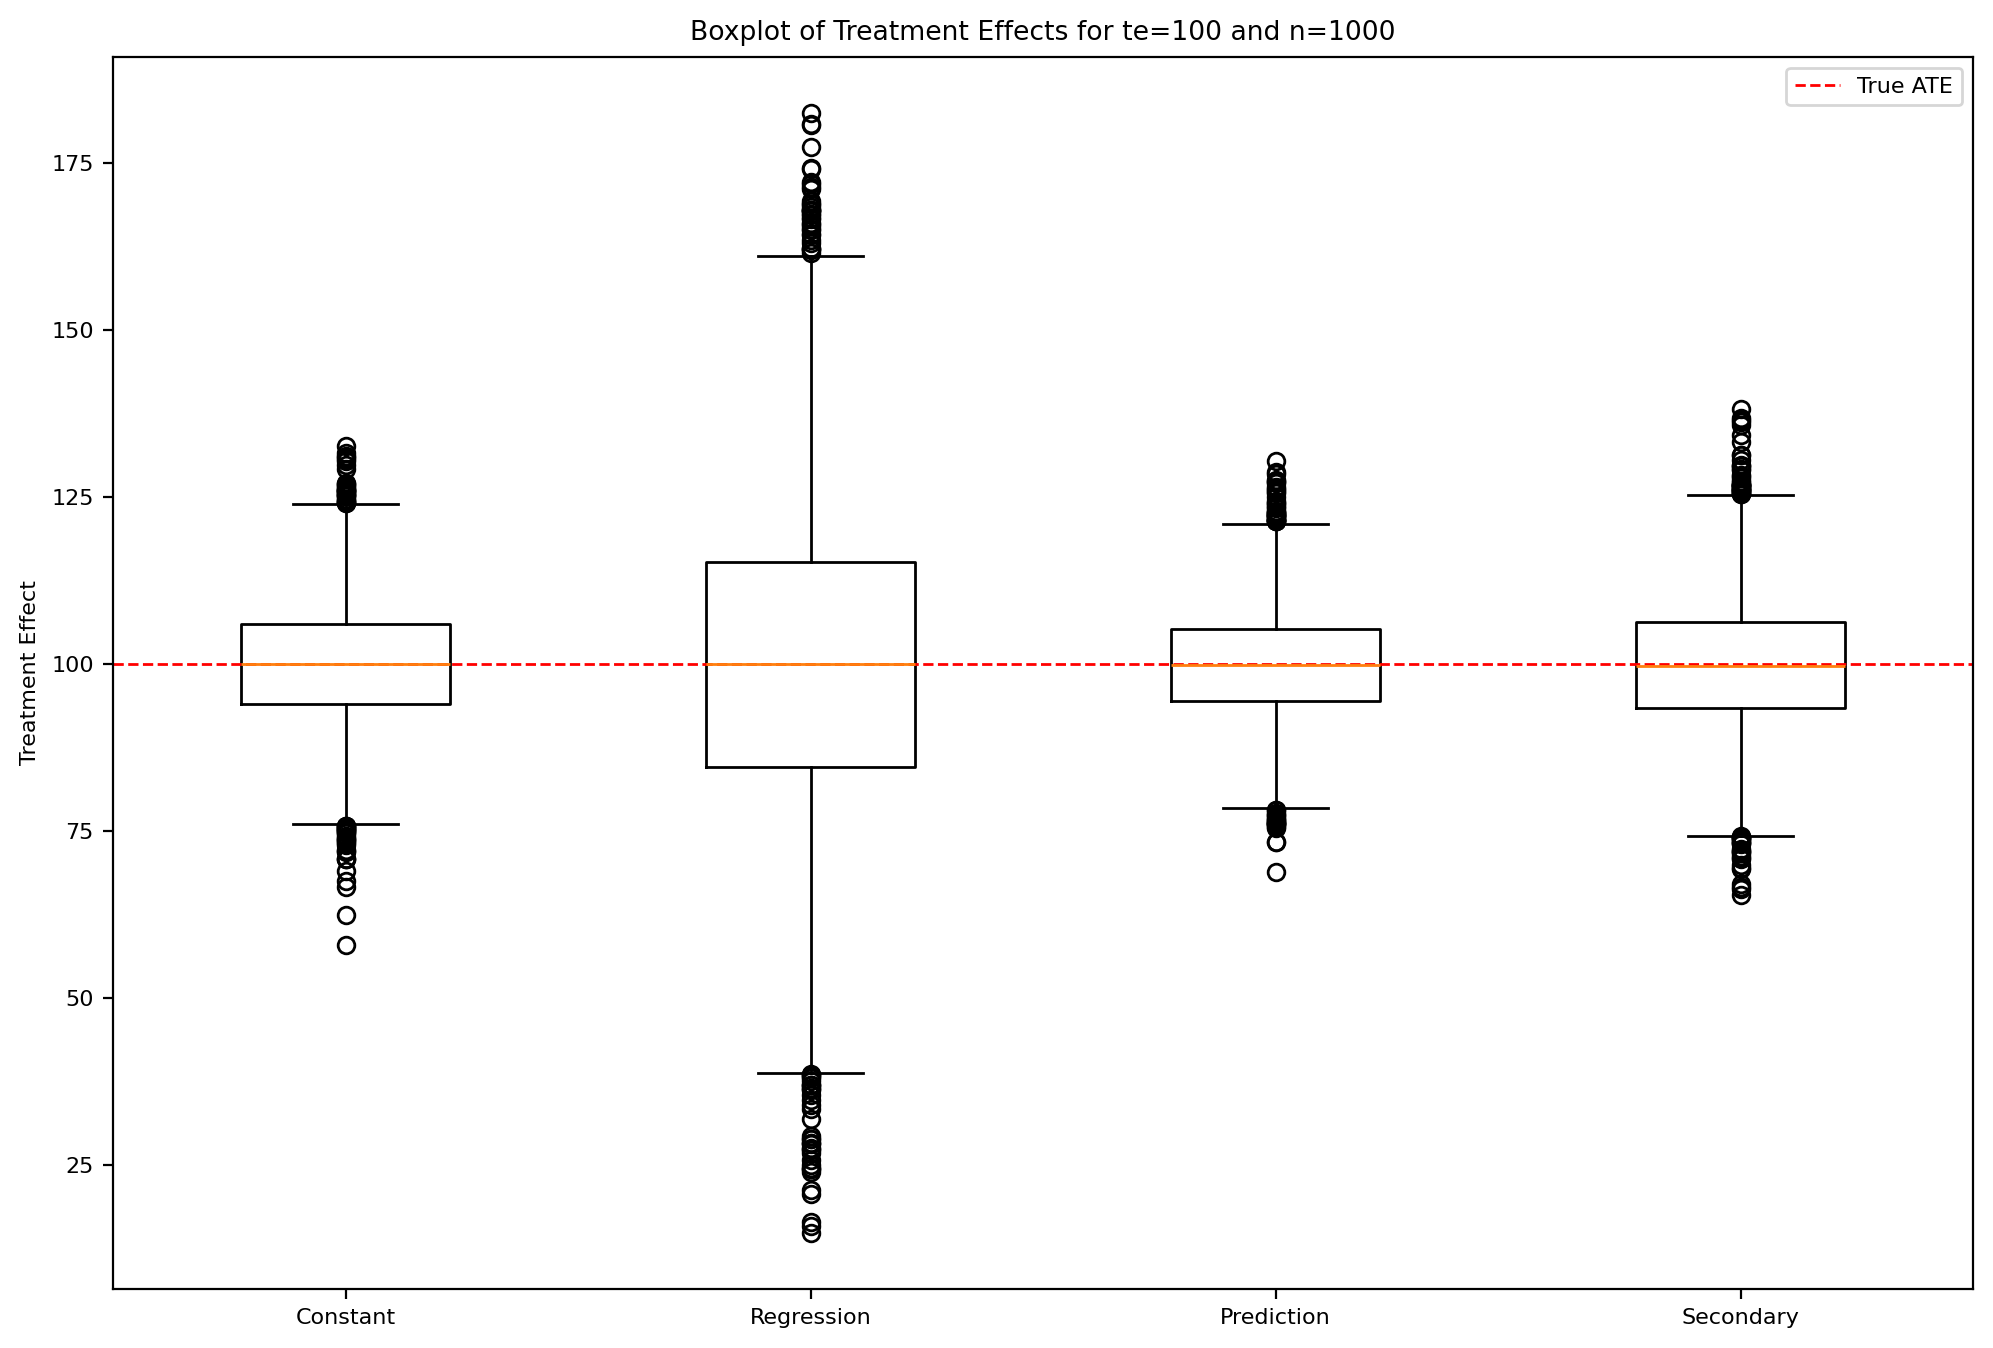

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


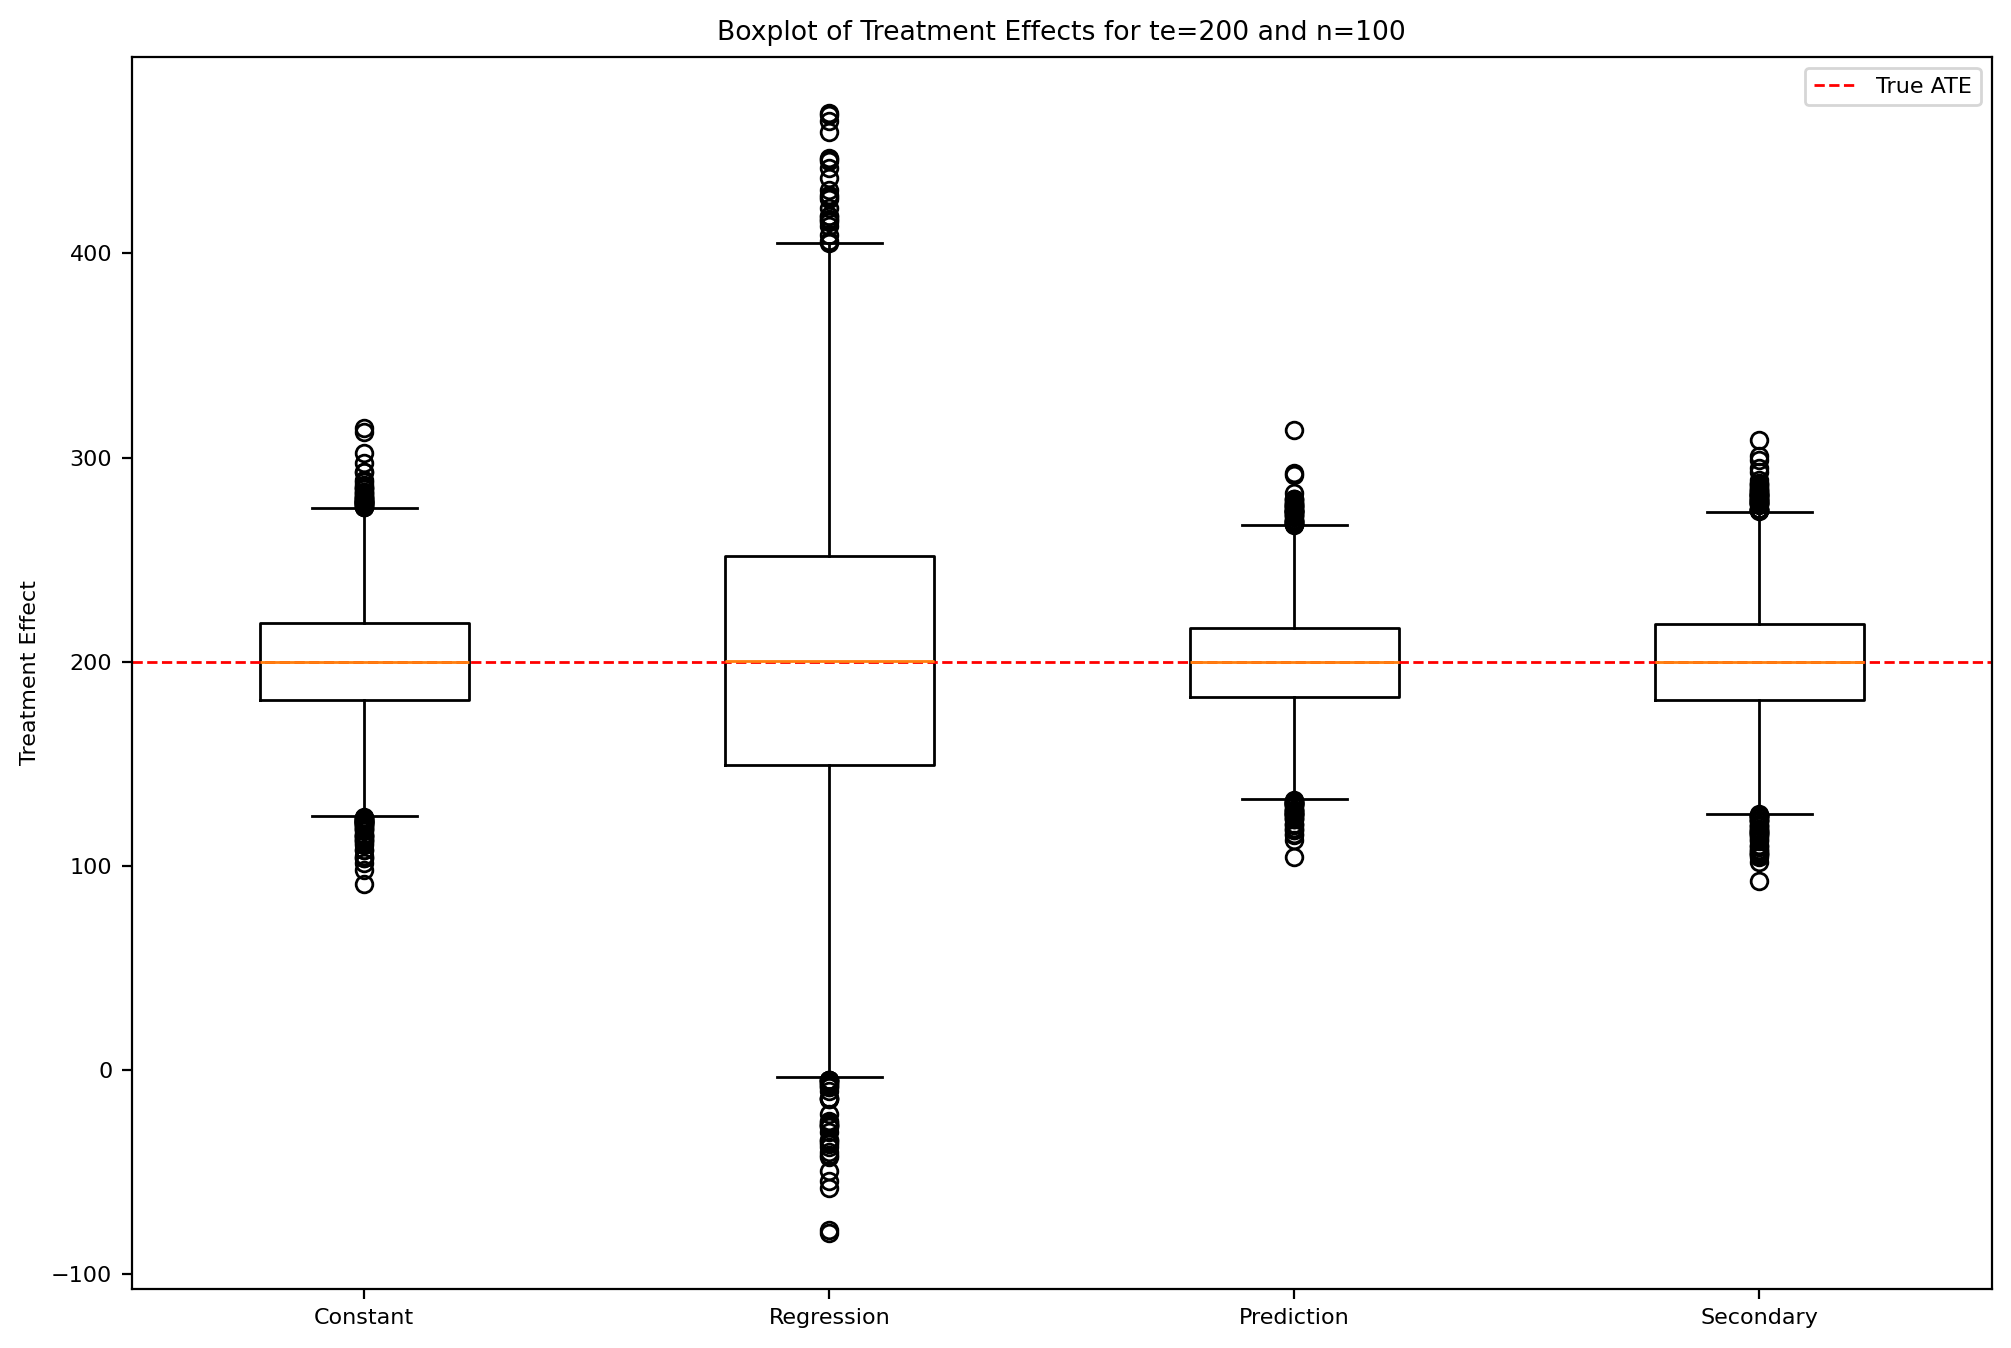

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


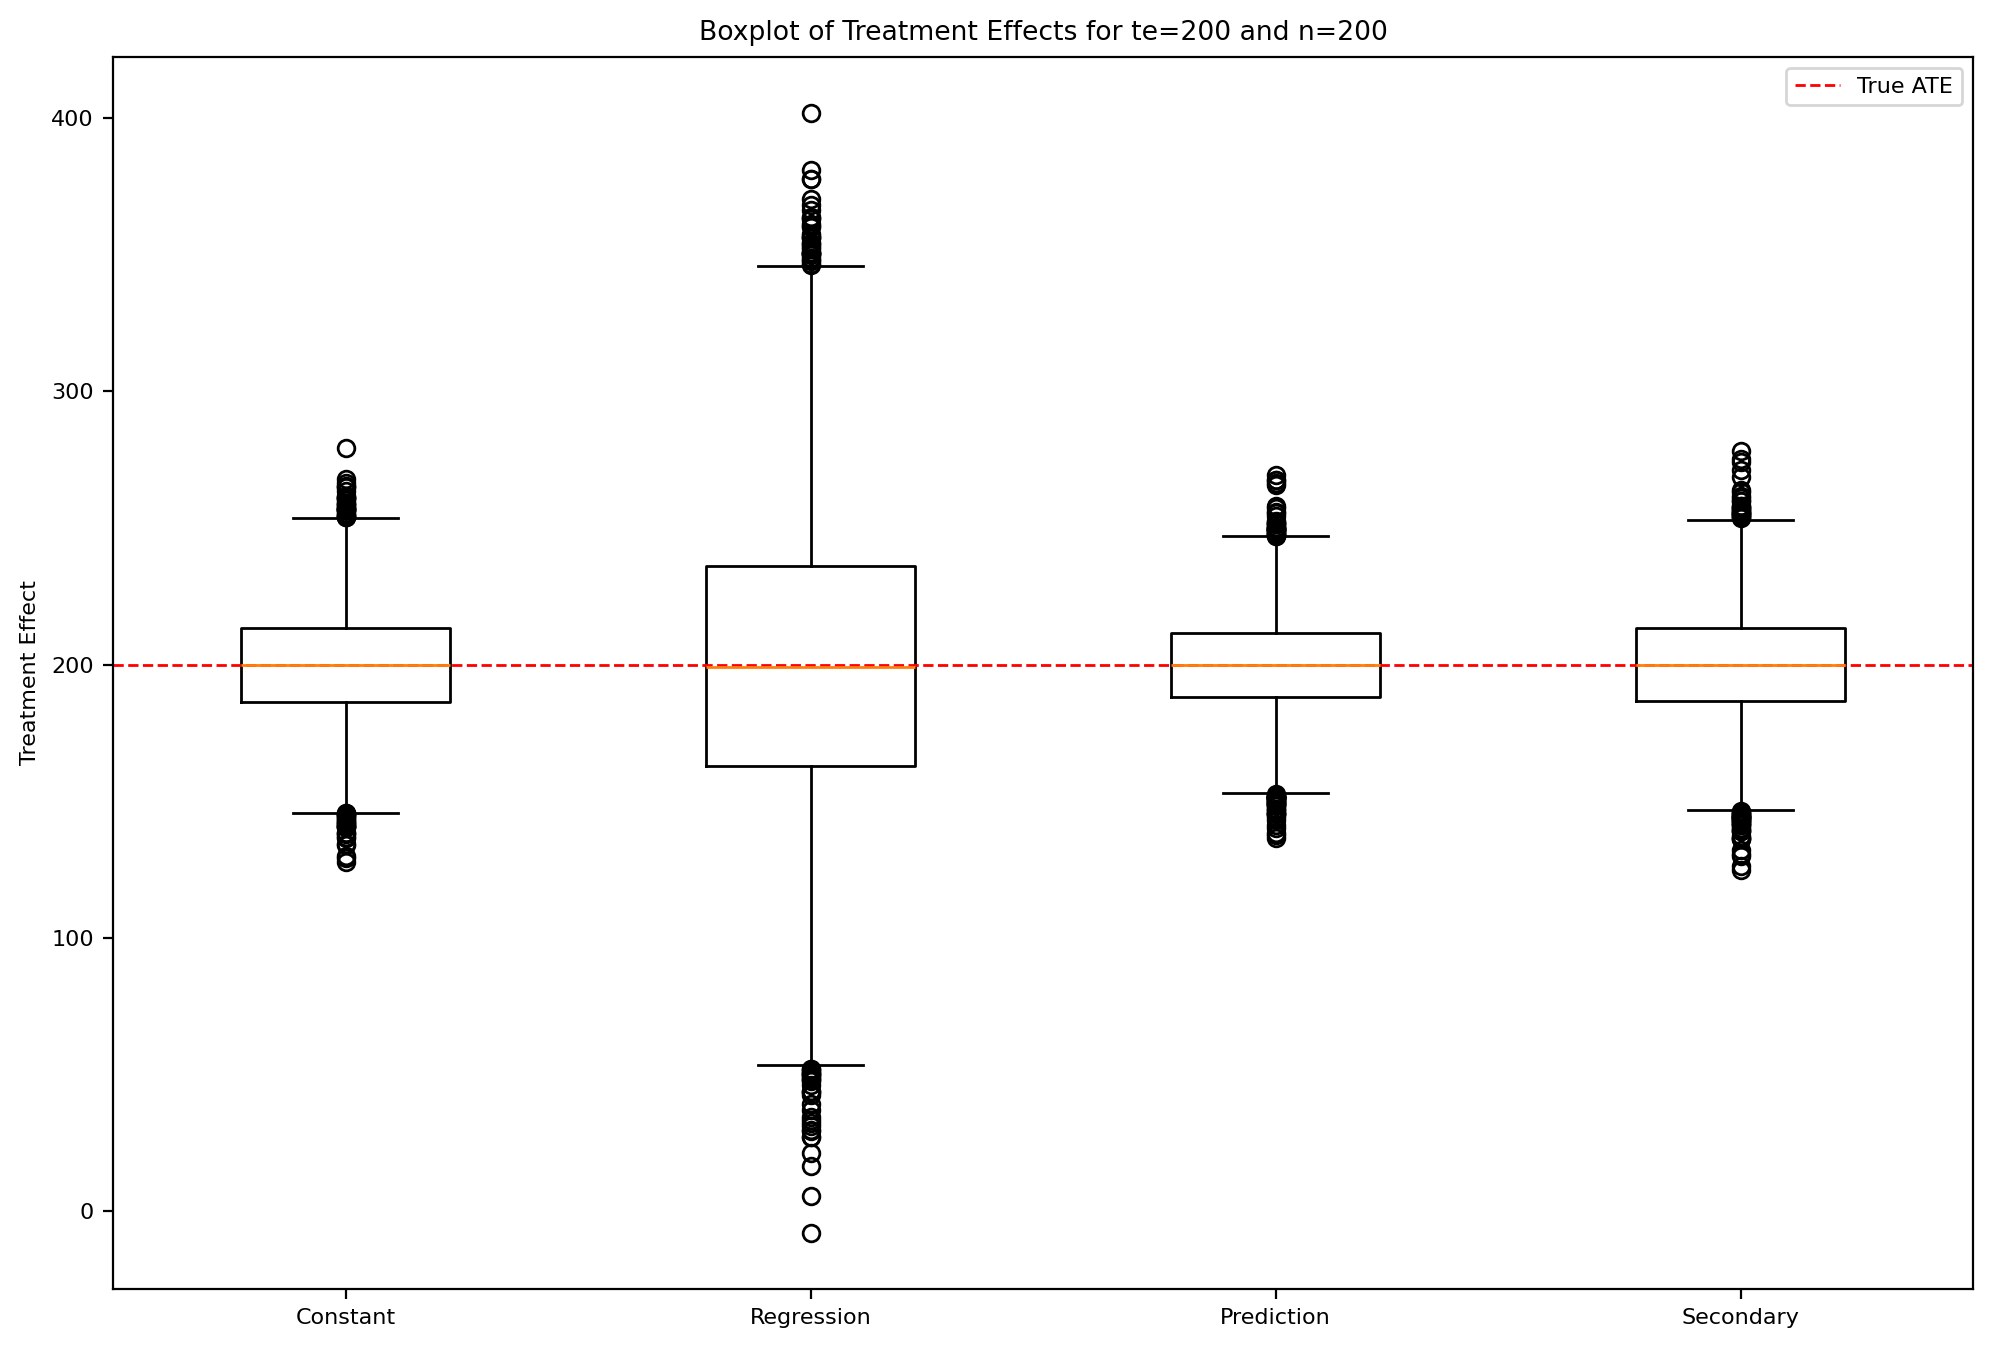

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


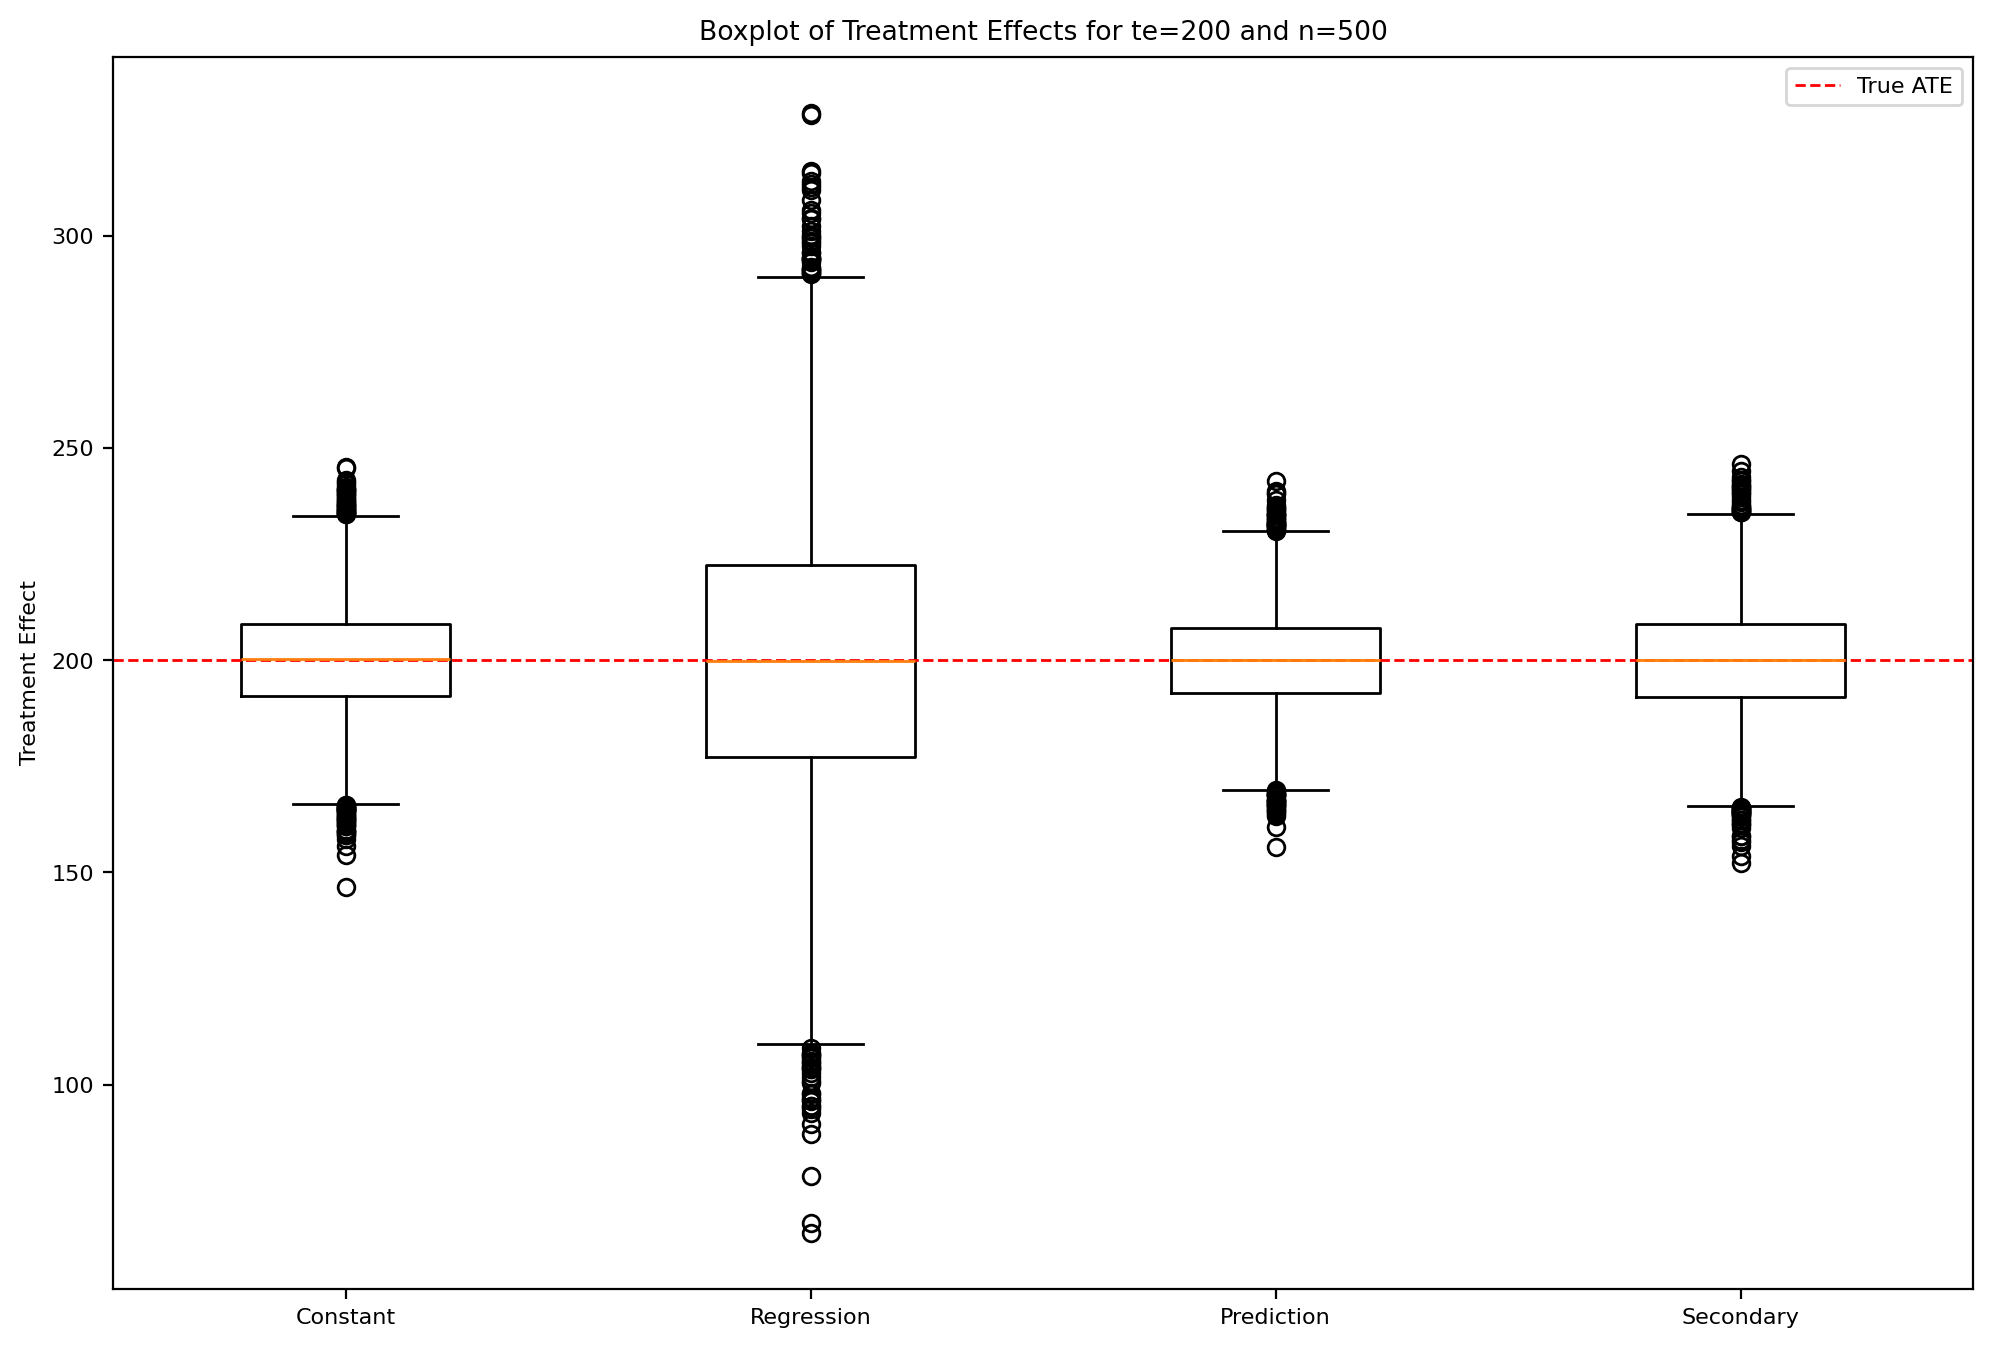

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_24888/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


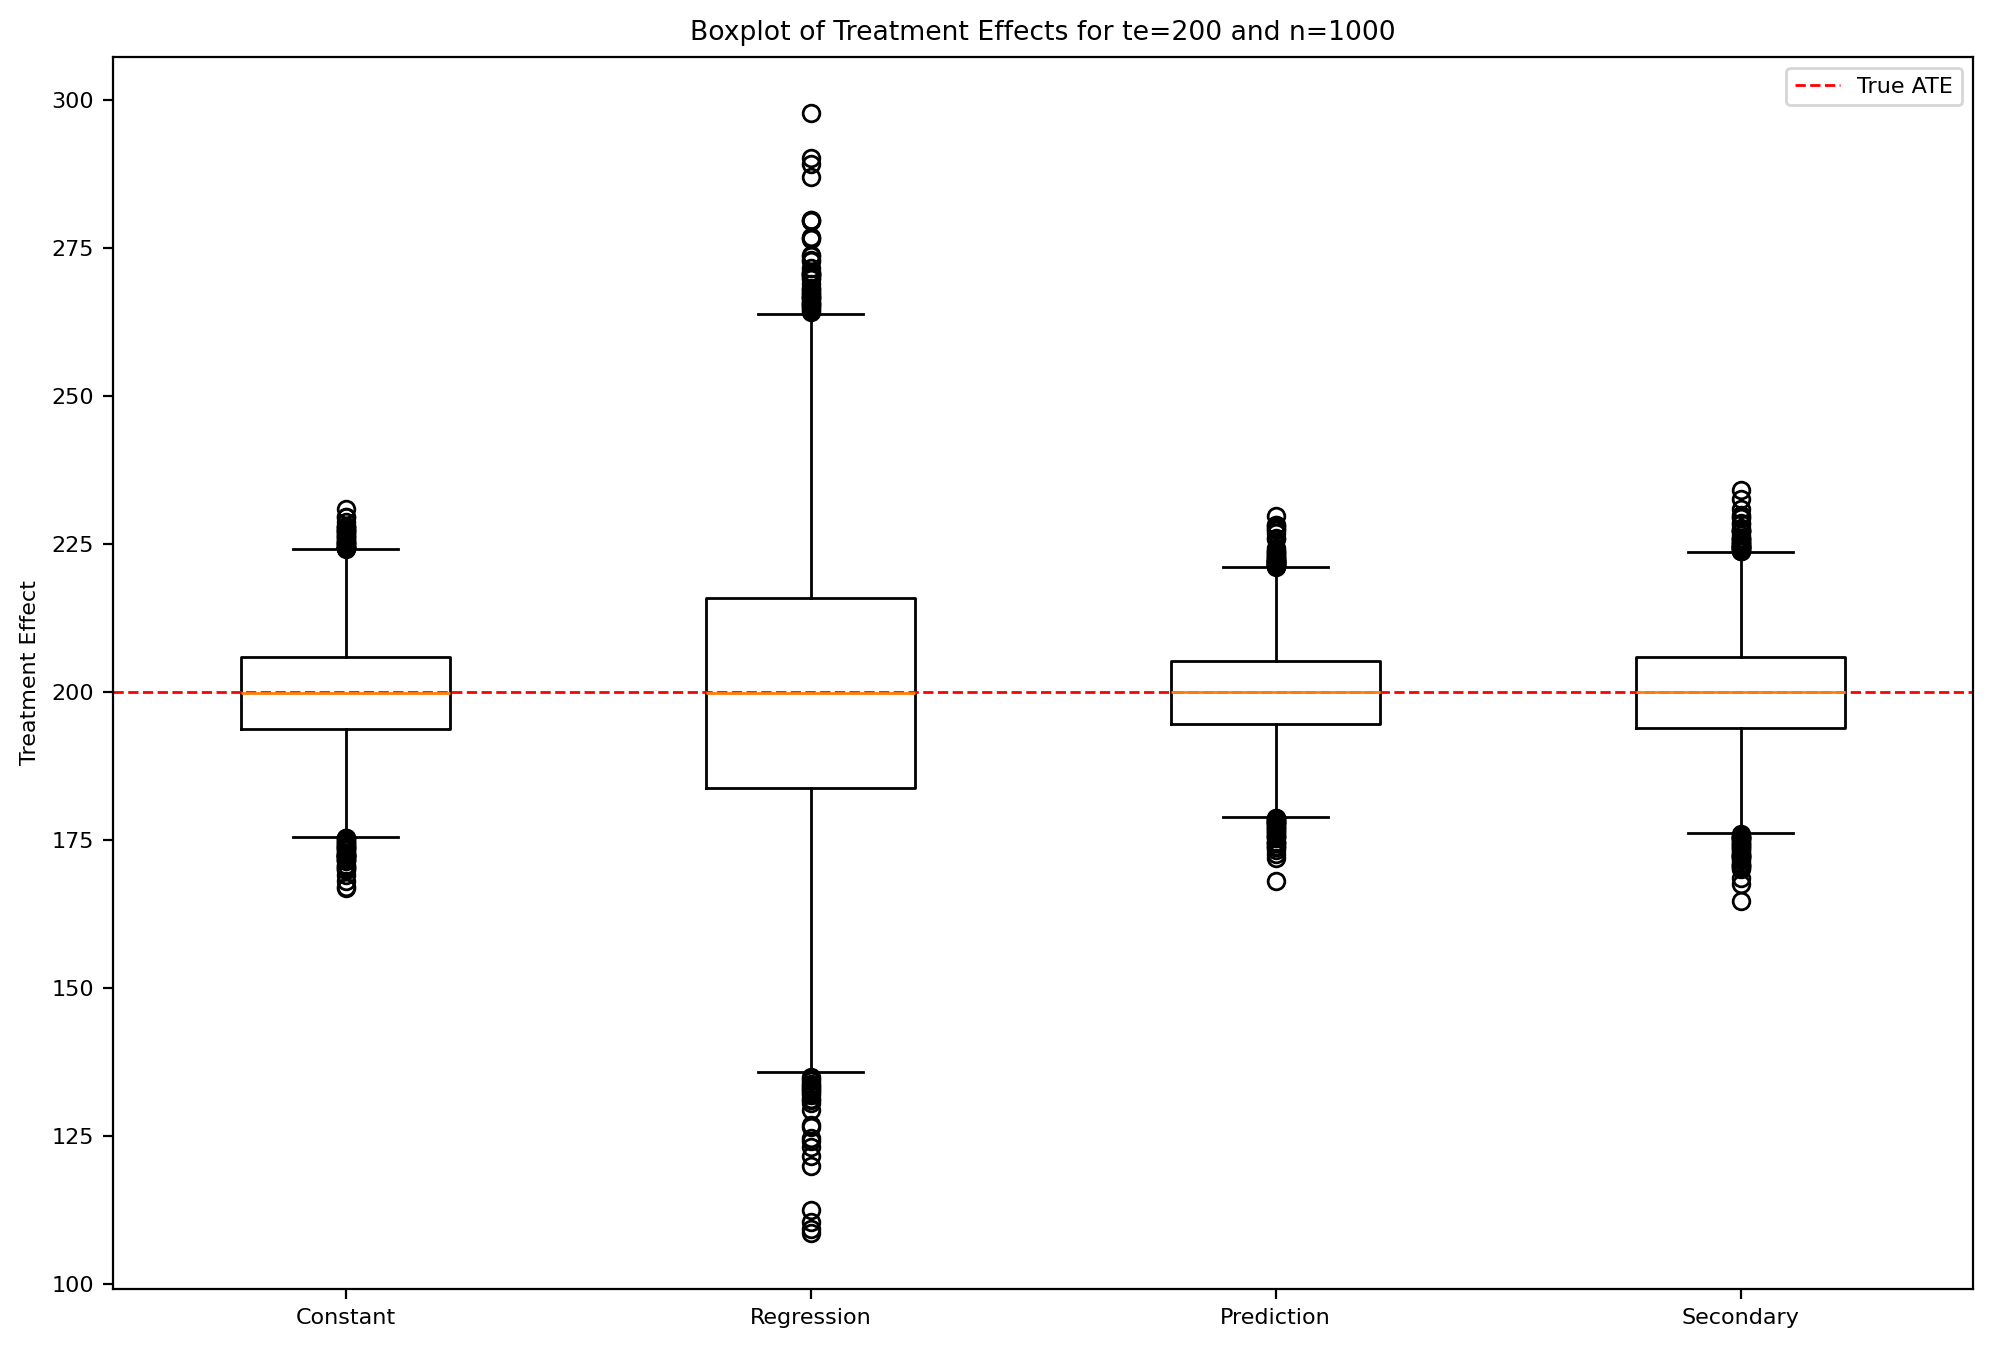

In [11]:
# Create boxplots for each combination of te and n
for te in te_lst:
    for n in n_lst:
        # Filter the results for the current combination of te and n
        subset = results.iloc[(idx - total):(idx - total + r)]
        
        # Create a new figure
        plt.figure(figsize=(12, 8), dpi=dpi)
        
        # Create boxplots for each method
        plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],
                    labels=['Constant', 'Regression', 'Prediction', 'Secondary'])
        
        # Add a horizontal line for the true treatment effect
        plt.axhline(y=te, color='r', linestyle='--', linewidth=1, label='True ATE')
        
        # Add title and labels
        plt.title(f'Boxplot of Treatment Effects for te={te} and n={n}')
        plt.ylabel('Treatment Effect')
        plt.legend()
        
        # Show the plot
        plt.show()
        # Update the index for the next subset
        idx += r